<a href="https://colab.research.google.com/github/miltondp/k99_courses/blob/main/cis_522/classes/01_24-week2/CIS_522_W2D2_Tutorial_%E2%80%93_Student_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 2 Part 2

# Deep Linear Networks

**Instructor:** Konrad Kording

**Content creators:** Ameet Rahane, Spiros Chavlis, Ann-Katrin Reuel


---

# Today's agenda

In the second tutorial of Week 2, we are going to dive deep into Linear Networks. One can see Linear Networks as the core models of Deep Learning; they are simple, mathematically easily interpretable, and of course, fun. Today we will:

1. Construct our first models in PyTorch using core modules
2. Solve the XOR logical operation, which is linearly non-separable, with a linear network
3. Investigate the initialization of our parameters
4. Examine how the network actual learns
5. Learn about different loss functions, and we can use them efficiently (optional: cosine similarity)
6. Give an intuition about the high dimensional spaces, the essence of Deep Learning. (optional)

Are you ready?


In [1]:
# @markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = "miltondp"  # @param {type:"string"}
my_pod = "Select"  # @param ["Factorial Ferrets", "Causal Crows", "Recursive Roosters", "Bayesian Bighorns", "Probabilistic Pronghorns", "Hashing Hares", "Multiplicative Mustangs", "Curiosity Capybaras", "Subspace Salamanders"]
my_email = "miltondp@gmail.com"  # @param {type:"string"}
tutorial = "W2D2"


# start timing
import time

try:
    t0
except NameError:
    t0 = time.time()


In [2]:
# @title Slides
from IPython.display import HTML

HTML(
    '<iframe src="https://docs.google.com/presentation/d/1SUfqb8AAF4ES1di7YUZ9WX3NJJuyrENYVyl3wtKxEos/embed?start=false&loop=false&delayms=3000" frameborder="0" width="480" height="299" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>'
)


/usr/local/lib/python3.8/dist-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


---

# Setup


In [3]:
# imports
import numpy as np
import random, time
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from tqdm.notebook import tqdm, trange

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [4]:
# @title Figure Settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline 

fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

plt.rcParams["mpl_toolkits.legacy_colorbar"] = False

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/"
              "course-content/master/nma.mplstyle")


In [5]:
#@title Helper functions

def synthetic_dataset(w, b, num_examples=1000, sigma=0.01, seed=2021):
  '''
  Synthetic data generator in the form:
      y = Xw + b + gaussian_noise(0, sigma).
  
  Parameters
  ----------
  w : torch.tensor
      weights. The length of `w` denotes the number of independent variables
  b : torch.tensor
      bias (offset or intercept).
  num_examples : INT, optional
      DESCRIPTION. The default is 1000.
  sigma : FLOAT, optional
      Standard deviation of the Gaussian noise. The default is 0.01.
  seed : INT, optional
      Seed the RNG for reproducibility. The default is 2021.
  
  Returns
  -------
  X: torch.tensor
      the independent variable(s).
  y: torch.tensor
      the dependent variable
  
  '''

  torch.manual_seed(seed)

  X = torch.normal(0, 1, (w.shape[0], num_examples))
  y = torch.matmul(w.T, X) + b
  # Add gaussian noise
  y += torch.normal(0, sigma, y.shape)
  if y.shape[0]==1:
      y = y.reshape((-1, 1))

  return X, y


def XOR_plots(activ_l1):
  from mpl_toolkits.axes_grid1 import AxesGrid
  fig = plt.figure()
  fig.subplots_adjust(left=0.05, right=0.95)
  grid = AxesGrid(fig, 111,  # similar to subplot(142)
                  nrows_ncols=(2, 5),
                  axes_pad=0.1,
                  share_all=False,
                  label_mode="1",
                  cbar_location="right",
                  cbar_mode="single",
                  )

  for i in range(2*5):
    im = grid[i].imshow(activ_l1[:, i].reshape(30,30), cmap='RdBu')
    grid[i].set_xlabel('X')
    grid[i].set_ylabel('Y')

  grid.cbar_axes[0].colorbar(im)
  cax = grid.cbar_axes[0]
  axis = cax.axis[cax.orientation]
  axis.label.set_text("$L_1$ output")

  for cax in grid.cbar_axes:
      cax.toggle_label(False)
    
  grid.axes_llc.set_xticks([0, 14, 29])
  grid.axes_llc.set_yticks([0, 14, 29])
  grid.axes_llc.set_xticklabels(['-1.1', '0', '1.1'])
  grid.axes_llc.set_yticklabels(['-1.1', '0', '1.1'])


  fig, axes = plt.subplots(nrows=2, ncols=5)
  cnt = 0
  for ax in axes.flat:
    ax.plot(np.sum(inputs.cpu().detach().numpy(), axis=1),
            activ_l1[:,cnt], '.')
    if cnt >= 5:
      ax.set_xlabel('X+Y')
    if cnt == 0 or cnt == 5:
      ax.set_ylabel('$L_1$ output')
    cnt += 1
  plt.tight_layout()



def XORpredictions(inputs, targets, preds):
  print('\nTest the model on XOR logical operation...')
  for input, target, pred in zip(inputs, targets, preds):
    print("Input:[{},{}] Target:[{}] Predicted:[{}] Error:[{}]".format(
      int(input[0]),
      int(input[1]),
      int(target[0]),
      round(float(pred[0]), 4),
      round(float(abs(target[0] - pred[0])), 4)
    ))


def plotRegression(X, y, preds, losses_xavier, losses_simple=None):
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.plot(losses_xavier, label='Xavier init.')
  if losses_simple:
    plt.plot(losses_simple, label='Simple init.')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Training loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.scatter(X.T, y.reshape(-1,1), label='original data')
  plt.plot(X.T, preds.detach().numpy(), label='regression',
          color='red', linewidth=3.0)
  plt.xlabel('independent variable')
  plt.ylabel('dependent variable')
  plt.title(f'Toy dataset, {N} samples')
  plt.legend()
  plt.show()


def plot_weight(losses, weights):
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.plot(losses)
  plt.xlabel('epoch')
  plt.ylabel('loss')

  plt.subplot(1, 2, 2)
  plt.plot(weights[0], label='Layer 1')
  plt.plot(weights[1], label='Layer 2')
  plt.plot(weights[2], label='Layer 3')
  plt.xlabel('epoch')
  plt.ylabel('weight')
  plt.legend()
  plt.show()


def plot_learning_modes(losses, epochs, modes, rank):
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.plot(losses)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Training loss')

  plt.subplot(1, 2, 2)
  plt.plot(range(epochs), modes.T)
  plt.legend(range(1,rank+1))
  plt.xlabel('epoch')
  plt.ylabel('singular value [a.u.]')
  plt.show()


def getData():
  # For regression with neural data
  !pip install spykes --quiet
  !pip install deepdish deepdish
  from spykes.plot.neurovis import NeuroVis
  from spykes.io.datasets import load_reaching_data
  from spykes.utils import train_test_split
  import pandas as pd
  # Download the dataset
  reach_data = load_reaching_data()

  print('dataset keys:', reach_data.keys())
  print('events:', reach_data['events'].keys())
  print('features', reach_data['features'].keys())
  print('number of PMd neurons:', len(reach_data['neurons_PMd']))


  # Get reach direction, ensure it is between [-pi, pi]
  y = np.arctan2(np.sin(reach_data['features']['endpointOfReach'] *
                np.pi / 180.0),
                np.cos(reach_data['features']['endpointOfReach'] *
                np.pi / 180.0))

  # Let's put the data into a DataFrame
  #
  # Events
  data_df = pd.DataFrame()
  events = ['targetOnTime', 'goCueTime', 'rewardTime']

  for i in events:
    data_df[i] = np.squeeze(reach_data['events'][i])


  data_df[events].head()

  ########################################################
  # Extract M1 spike counts Y
  # ~~~~~~~~~~~~~
  # - Select only neurons above a threshold firing rate
  # - Align spike counts to the GO cue
  # - Use the convenience function ```get_spikecounts()``` from ```NeuroVis```

  # Select only high firing rate neurons
  M1_select = list()
  threshold = 10.0

  # Specify timestamps of events to which trials are aligned
  align = 'goCueTime'

  # Specify a window of around the go cue for spike counts
  window = [0., 500.]  # milliseconds

  # Get spike counts
  X = np.zeros([y.shape[0], len(reach_data['neurons_M1'])])

  for n in range(len(reach_data['neurons_M1'])):
    this_neuron = NeuroVis(spiketimes=reach_data['neurons_M1'][n])
    X[:, n] = np.squeeze(
        this_neuron.get_spikecounts(event=align,
                                    df=data_df,
                                    window=window))

    # Short list a few high-firing neurons
    if this_neuron.firingrate > threshold:
      M1_select.append(n)

  # Rescale spike counts to units of spikes/s
  X = X / float(window[1] - window[0]) * 1e3

  ########################################################
  # Split into train and test sets (2/3 training, 1/3 test)
  # ~~~~~~~~~~~~~

  (x_train, x_test), (y_train, y_test) = train_test_split(X, y, percent=0.10)

  return (x_train, y_train, x_test, y_test)


def reaching_test(x_test, y_test, yhat_test):
  # Visualize decoded reach direction
  L = x_test.shape[0]
  x1 = ["Original values"] * L
  x2 = ["Predicted values"] * L

  # Define all pairs to draw lines
  lines = [[x, list(zip([1]*L, yhat_test.cpu().detach().numpy()))[i]]
          for i, x in enumerate(zip([0]*L, y_test))]
  lc = LineCollection(lines)

  fig, ax = plt.subplots(nrows=1, ncols=2)
  ax[0].scatter(x1, y_test, color='k', alpha=0.5)
  ax[0].scatter(x2, yhat_test.cpu().detach().numpy(), color='g', alpha=0.5)
  ax[0].add_collection(lc)
  ax[0].set_ylabel('reaching angle (radians)')
  ax[0].set_ylim([-1.2 * np.pi, 1.2 * np.pi])

  ax[1].plot(y_test, yhat_test.cpu().detach().numpy(), 'k.', alpha=0.5)
  ax[1].plot(y_test, y_test, 'r--', linewidth=1.8, label='$y=x$')
  ax[1].set_xlim([-1.25 * np.pi, 1.25 * np.pi])
  ax[1].set_ylim([-1.2 * np.pi, 1.2 * np.pi])
  ax[1].set_xlabel('True values (radians)')
  ax[1].set_ylabel('Prdicted values (radians)')
  plt.legend()
  plt.show()


def loss_comparison(lossesMAE, lossesMSE,
                    losses_testMAE, losses_testMSE, 
                    MSE_test, MAE_test):
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.plot(lossesMSE, label='MSE-training')
  plt.plot(lossesMAE, label='MAE-training')
  plt.xlabel('epoch')
  plt.ylabel('loss [a.u.]')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(losses_testMSE, label='MSE-test')
  plt.plot(losses_testMAE, label='MAE-test')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

  print("\nErrors in the test set using both models")
  print (f"Test set: using L1 loss function (MAE): {MAE_test}")
  print (f"Test set: L2 loss function (MSE): {RMSE_test}")


from sklearn.preprocessing import OneHotEncoder


def idx_word(docs):
  '''
  Function to give an index to every word found in doc

  Parameters
  ----------
  docs : list of STR
      Contains the text

  Returns
  -------
  idx_2_word : dictionary
    assign an index to every word.
  word_2_idx : dictionary
    assign a word to every index.
  '''
  idx_2_word = {}
  word_2_idx = {}
  temp = []
  i = 1
  for doc in docs:
    for word in doc.split():
      if word not in temp:
        temp.append(word)
        idx_2_word[i] = word
        word_2_idx[word] = i
        i += 1
        
  return (idx_2_word, word_2_idx)


def one_hot_map(doc, word_2_idx):
  '''
  Translate each document `doc` into a vector with integers
  Parameters
  ----------
  doc : STR
    The text to be translated.

  Returns
  -------
  x : LIST
    Sentence in INTEGER format.

  '''
  x = []
  for word in doc.split():
    x.append(word_2_idx[word])
  return x


def combinations(lst):
  index = 1
  pairs = []
  for element1 in lst:
    for element2 in lst[index:]:
      pairs.append([element1, element2])
    index += 1

  return pairs


def padding_seqs(original_seqs,
                 value=0,
                 max_len=None,
                 padding='post',
                 truncate='post'):
  '''
  A function that adds `value` at the end  of
  each sequence in `original_seqs`.

  Parameters
  ----------
    original_seqs: List of sequences (each sequence is a list of integers).
    value: Float or String, padding value. (Optional, defaults to 0.)
    maxlen: Optional Int, maximum length of all sequences. If not provided,
        sequences will be padded to the length of the longest individual
        sequence.
    padding: String, 'pre' or 'post' (optional, defaults to 'pre'):
        pad either before or after each sequence.
    truncating: String, 'pre' or 'post' (optional, defaults to 'pre'):
        remove values from sequences larger than
        `max_len`, either at the beginning or at the end of the sequences.
  Returns:
    Numpy array with shape `(len(sequences), maxlen)`
  '''
  if not max_len:
    max_len = max([len(i) for i in original_seqs])

  padded_seqs = []

  if padding == 'post':
    for seq in original_seqs:
      if (max_len - len(seq)) >= 0:
        seq_pad = seq + [value] * (max_len - len(seq))
      else:
        if truncate == 'post':
          seq_pad = seq[:max_len]
        elif truncate == 'pre':
          seq_pad = seq[(len(seq) - max_len):]

      padded_seqs.append(seq_pad)

  elif padding == 'pre':
    for seq in original_seqs:
      if (max_len-len(seq)) >= 0:
        seq_pad = [value] * (max_len - len(seq)) + seq
      else:
        if truncate == 'post':
          seq_pad = seq[:max_len]
        elif truncate == 'pre':
          seq_pad = seq[(len(seq) - max_len):]

      padded_seqs.append(seq_pad)

  return (np.array(padded_seqs))


In [6]:
# @title Set seed for reproducibility
seed = 2021
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


print("Seed has been set.")


Seed has been set.


---

# Section 1: Deep linear networks

## How they can be seen as an approximation to DL later in the course.

_Estimated time: 15 minutes since start_


Video available at https://youtube.com/watch?v=Yy68K5STSMA


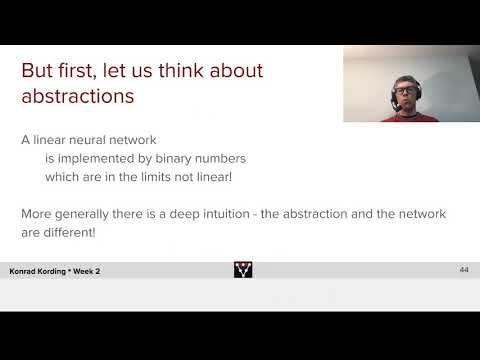

In [7]:
# @title Video: Deep Learning, the Abstraction and the Implementation

try:
    t1
except NameError:
    t1 = time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="Yy68K5STSMA", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


## Section 1.2: `nn.Sequential` class

In the previous [Tutorial](https://colab.research.google.com/github/CIS-522/course-content/blob/main/tutorials/W2_PyTorchDLN/student/W2_Tutorial1.ipynb), we have verified that PyTorch predefined models work as expected (obviously!!!). Here, we will learn two approaches to construct our models.


First, we will use the `nn.Sequential` class to construct our model as a function. You may use `? nn.Sequential` in a _scratch cell_ to see its Docstring.

`nn.Sequential` is a container of Modules added to it in the order they are passed in the constructor. Alternatively, we can pass an ordered dictionary of modules in the class.

```python
# Example of using Sequential
model = nn.Sequential(
          nn.Linear(15,10),
          nn.Linear(10,8)
        )
```

In this code snippet, we have created a model with one hidden layer.


### Exercise 1: Construct a Linear Neural Network

Now is your turn to implement a model consisting of two hidden layers.


In [8]:
# Build a linear network with 2 hidden layers using nn.Sequential model
input_dim = 1
output_dim = 1
hidden_1 = 10
hidden_2 = 10


def model(input_dim, hidden_1, hidden_2, output_dim):
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    #raise NotImplementedError("Add the missing layers")
    ####################################################################
    net = nn.Sequential(
        nn.Linear(input_dim, hidden_1),
        nn.Linear(hidden_1, hidden_2),
        nn.Linear(hidden_2, output_dim),
      )
    return net


## uncomment the line below to test your function
my_net = model(input_dim, hidden_1, hidden_2, output_dim)
print(my_net)


Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)


## Section 1.2: `nn.Module` class

Another approach is to write a custom class (`nn.Module`). This approach lets us implement custom NN functions and provides more flexibility and better handling.

`nn.Module` is a base class for all neural network modules. Your models should also subclass this class. Modules can also contain other Modules, allowing them to nest in a tree structure. You can assign the submodules as regular attributes.

```python
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.linear1 = nn.Linear(1, 10)  # input to hidden layer
    self.linear2 = nn.Linear(10, 1)  # hidden to output layer

  def forward(self, x):
    h1 = self.linear1(x)
    return self.linear2(h1)
```

In this code snippet, we have created a Model with one hidden layer.


If we want to add more layers or if we want to explore the performance of our model concerning the number of hidden layers, we can use the `nn.ModuleList` to create a list containing the hidden layers. `nn.ModuleList` can be indexed like a regular Python list. Below we give a simple example:

```python
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()

    self.hidden_layers = nn.ModuleList()  # initialize an empty list
    input_dim = 32
    self. hidden_units = [16, 8, 4]
    # A fully-connected network (FCN) with len(hidden_units) hidden layers
    for i in range(len(hidden_units)):
      self.hidden_layers += [nn.Linear(input_dim, self.hidden_units[i])]
      input_dim = self.hidden_units[i]  # output of layer L-1 is the input in Layer L
    # create the output layer
    self.out = nn.Linear(input_dim, 1)

  # forward pass
  def forward(self, x):
    for layer in self.hidden_layers:
      x = layer(x)
    return self.out(x)
```

For the next exercise, let's use the simple `nn.Model` class without incorporating the `nn.ModuleList`, but feel free to explore this possibility.


### Exercise 2: Construct the same network using the `nn.Module` class

Now is your time to write some lines of code. Here, you will build a model with two hidden layers.


In [9]:
# Build a linear network with 2 hidden layers using nn.Module class


class Net(nn.Module):
    def __init__(self, input_dim, hidden_1, hidden_2, output_dim):
        super(Net, self).__init__()

        self.input_dim = input_dim
        self.hidden_1 = hidden_1
        self.hidden_2 = hidden_2
        self.output_dim = output_dim

        # Create a fully-connected network (FCN) with 2 hidden layers
        self.fc1 = nn.Linear(self.input_dim, self.hidden_1)
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        # raise NotImplementedError("Define the two hidden layers")
        ####################################################################
        self.fc2 = nn.Linear(self.hidden_1, self.hidden_2)
        self.fc3 = nn.Linear(self.hidden_2, self.output_dim)

    def forward(self, x):
        h1 = self.fc1(x)
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        # raise NotImplementedError("Calculate the forward pass")
        ####################################################################
        h2 = self.fc2(h1)
        out = self.fc3(h2)

        return out


## uncomment the line below to test your function
my_net2 = Net(input_dim, hidden_1, hidden_2, output_dim)
print(my_net2)


Net(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)


Please feel free to implement the network using any other approach that is more comfortable for you!


---

# Section 2: Back to actual linear neural networks

## Let's make it deep (should have no effect, right?)

_Estimated time: 35 minutes since start_


Video available at https://youtube.com/watch?v=5w9byiqPeO0


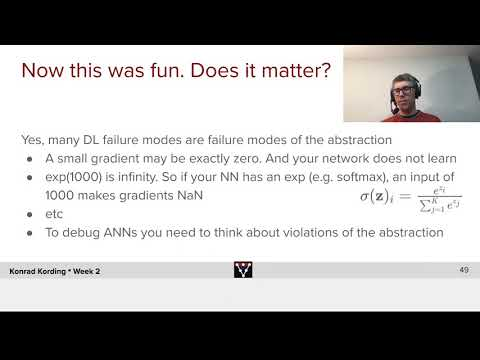

In [10]:
# @title Video: Deep Linear ANNs

try:
    t3
except NameError:
    t3 = time.time()

video = YouTubeVideo(id="5w9byiqPeO0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


First, we construct our toy dataset, which consists of independent variables in $1D$ space to make the illustration easier. Let's build the dataset and then plot it.


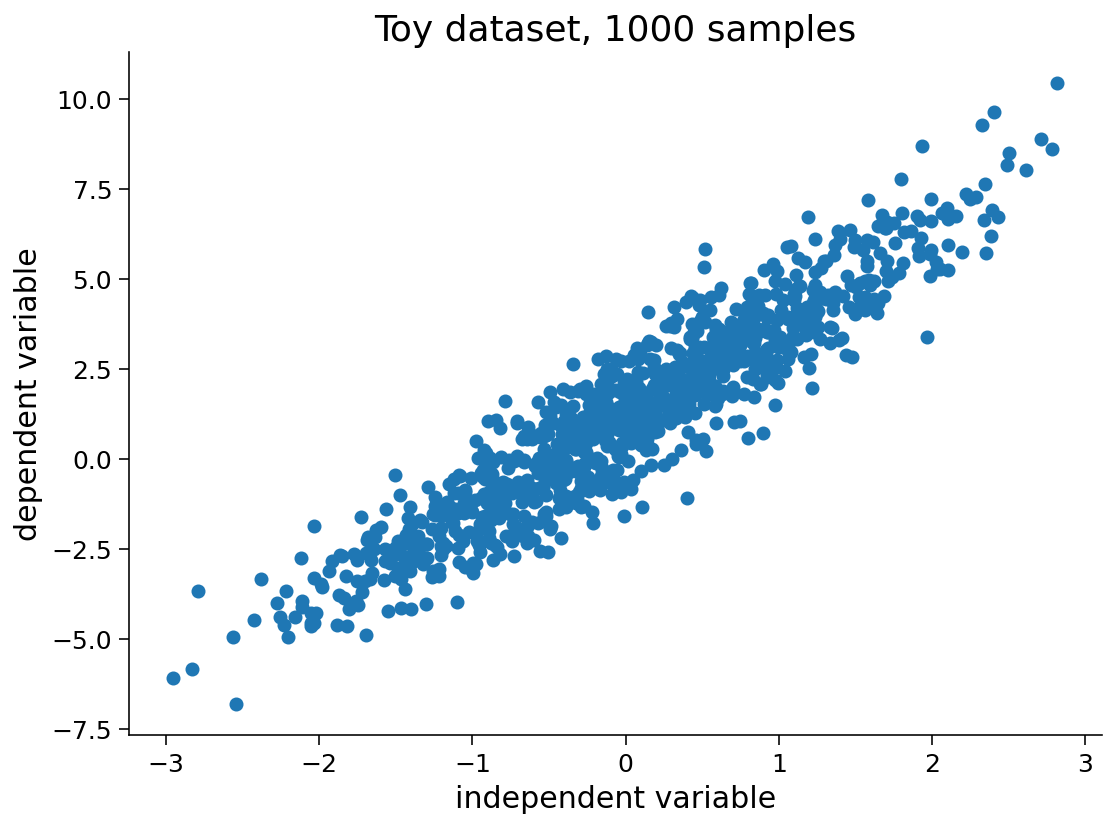

In [11]:
# Dataset

original_w = torch.tensor([2.5]).reshape(-1, 1)
original_b = 1.2
N = 1000  # number of examples
X, y = synthetic_dataset(original_w, original_b, num_examples=1000, sigma=1.0)

plt.figure()
plt.scatter(X.T, y)
plt.xlabel("independent variable")
plt.ylabel("dependent variable")
plt.title(f"Toy dataset, {N} samples")
plt.show()


First, we will construct a Linear Regression model (one input and one output), similar to [Tutorial 1](https://colab.research.google.com/github/CIS-522/course-content/blob/main/tutorials/W2_PyTorchDLN/student/W2_Tutorial1.ipynb). We initialize the parameters very close to zero. Run the cell and see what happens.


loss:   0%|          | 0/250 [00:00<?, ?it/s]

The loss after training is: 0.9740965366363525


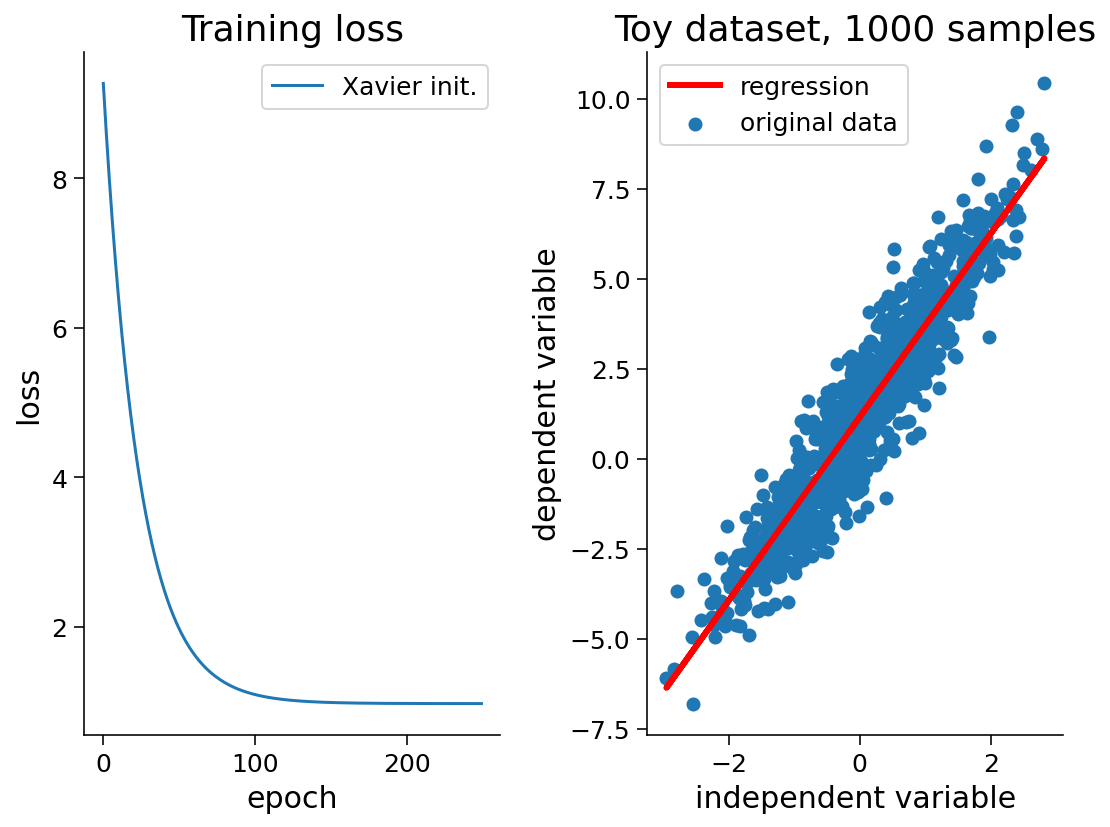

In [12]:
def deepNetwork(deep=False):
    # Network parameters
    input_dim = 1
    output_dim = 1

    if deep:
        h1, h2, h3, h4, h5, h6 = 20, 15, 10, 5, 4, 2
        # define our network
        net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.Linear(h1, h2),
            nn.Linear(h2, h3),
            nn.Linear(h3, h4),
            nn.Linear(h4, h5),
            nn.Linear(h5, h6),
            nn.Linear(h6, output_dim),
        )
    else:
        # define our network
        net = nn.Sequential(nn.Linear(input_dim, 1))

    # parameters initialization
    sigma = 1e-11
    for i in range(len(net)):
        net[i].weight.data.normal_(0, sigma)
        net[i].bias.data.fill_(0)

    return net


def training_loop(X, y, model, learning_rate=0.01, num_epochs=250):
    # Training
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    losses = []

    epoch_range = trange(num_epochs, desc="loss: ", leave=True)

    for epoch in epoch_range:
        if losses:
            epoch_range.set_description("loss: {:.6f}".format(losses[-1]))
            epoch_range.refresh()  # to show immediately the update
        time.sleep(0.01)

        loss = criterion(model(X.T), y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.item())

    # Calculate loss
    preds = model(X.T)
    loss = criterion(preds, y)
    print(f"The loss after training is: {loss}")

    return (preds, losses)


# Create a shallow network
net = deepNetwork(deep=False)
output = training_loop(X, y, model=net)
plotRegression(X, y, output[0], output[1])


Now, let's make the network deep. As we have a linear network, the depth shouldn't matter, should it?

In a pure linear network with $L$ layers, the output is calculated by:

\begin{equation}
Y = \text{W}_{[L]}\text{W}_{[L-1]} \dots \text{W}\_{[1]} \textbf{X} = \text{Q} \textbf{X}
\end{equation}

So, a deep linear network can be approximated by a single layer linear network!

However, these are mathematics. Let's see a deep linear network in action. Run the code and see if the network learns or not. Notice that all parameters across the two networks are the same!


loss:   0%|          | 0/250 [00:00<?, ?it/s]

The loss after training is: 7.652220726013184


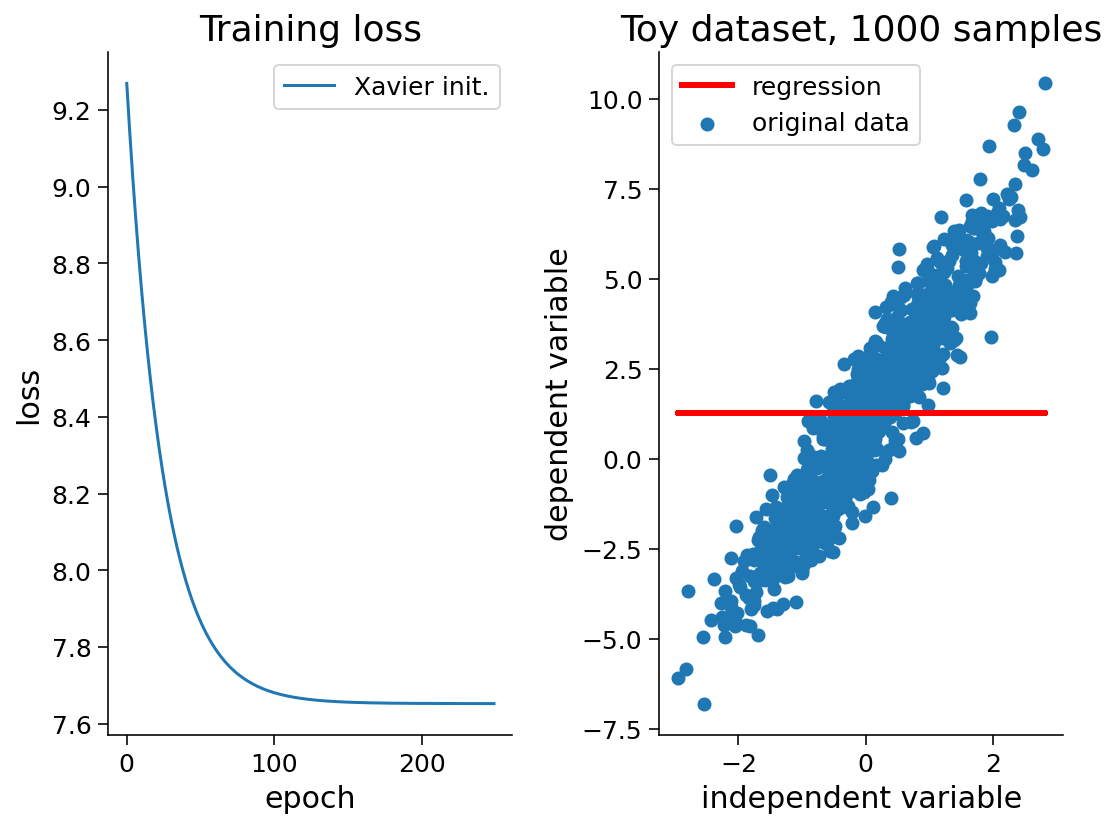

In [13]:
# Create a deep network
net = deepNetwork(deep=True)
output = training_loop(X, y, model=net)
plotRegression(X, y, output[0], output[1])


It seems that our Deep NN fails to learn a straightforward task... Why is this happening? Maybe we have initialized the parameters wrongly.


---

# Section 3: The need for clever network initialization

## How to do it right

_Estimated time: 60 minutes since start_

Until now, we took the initialization scheme for granted, bypassing how these choices are made. For example, in Tutorial 1, we initialized the weights to zero in the simple linear regression case. Can we do the same with neural networks? As you have seen before, in deep networks, we can't.

You might think that these choices are not especially important. However, the choice of parameter initialization scheme plays a crucial role in neural network learning, and it can be vital to avoid numerical instabilities. We initialize the parameters to determine how quickly our optimization algorithm converges, in simple words, how fast our network learns.

-   What happens when we initialize weights too big? The gradient (a product of matrices from backpropagation/the chain rule) is much larger in the first than in the last layers, which causes extreme weight updates that overshoot the target or explode to infinity or `NaN`. This phenomenon is called **exploding gradient problem**.

-   What happens when we initialize weights too small? The gradient tends to get smaller as we move backward, which means the gradients in the first layers are tiny or zero. This phenomenon is called **vanishing gradient problem**.

Poor weight initialization choices lead to **exploding** or **vanishing** gradients while training and can prevent the network from learning anything.

When we initialize our parameters, we would like to:

-   Initialize around zero
-   Sample from a gaussian distribution with standard deviation $\sigma$ or from a uniform distribution in $[-\sigma,\sigma]$


## Section 3.1 Xavier initialization


Video available at https://youtube.com/watch?v=gEH7hHkPn8Y


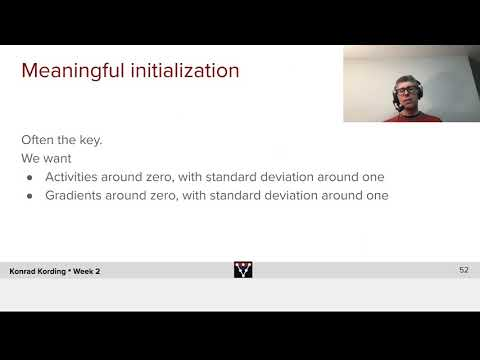

In [14]:
# @title Video: Xavier Initialization

try:
    t4
except NameError:
    t4 = time.time()

video = YouTubeVideo(id="gEH7hHkPn8Y", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


Let us look at the scale distribution of an output (e.g., a hidden variable) $o_i$ for some fully-connected layer. With $n_{in}$ inputs $x_j$ and their associated weights $w_{ij}$ for this layer, an output is given by

\begin{equation}
o_i = \sum_{j=1}^{n_{in}} w_{ij}x_{j}
\end{equation}

The weights are drawn independently from the same distribution, which is not necessarily a Gaussian. Let us assume that this distribution has zero mean and standard deviation $\sigma_{w}$ (variance $\sigma_{w}^2$). For now, let us assume that the inputs to the layer $x_j$ also have zero mean and variance $\sigma_{x}^{2}$ and that they are independent of $w_{ij}$ and independent of one another other. With this assumptions, we can compute the mean and variance of $o_i$ as follows:

\begin{align}
\mathbb{E}[o_i] &{} \stackrel{def} = \sum_{j=1}^{n_{in}}\mathbb{E}[w_{ij}x_{j}] & \\
&{} = \sum_{j=1}^{n_{in}}\mathbb{E}[w_{ij}]\mathbb{E}[x_{j}] & \text{(independence of $w$ and $x$)}\\
&{} = 0 & \text{(each has mean $0$)}
\end{align}

\begin{align}
Var[o_i] & {} \stackrel{def} = \mathbb{E}[o_i^{2}] - \left( \mathbb{E}[o_i] \right)^{2} & \\
& {} = \sum_{j=1}^{n_{in}} \mathbb{E}[w_{ij}^{2}x_{j}^{2}] - 0 & \\
&{} = \sum_{j=1}^{n_{in}} \mathbb{E}[w_{ij}^{2}]\mathbb{E}[x_{j}^{2}] & \text{(independence of $w$ and $x$)} \\
\sigma_o^2 &{} = n_{in}\sigma_{w}^{2}\sigma_{x}^{2}
\end{align}

Let's see this equation in action:


In [15]:
n_in, n_out = 256, 1000

# Create mean 0 variance 1 weights
W = torch.randn(n_out, n_in)
# Create mean 0 variance 1 input activations
x = torch.randn(n_in, 1)
# Linear layer: matrix-multiply W times x
o = W @ x

print(f"output mean = {o.mean().item()}")
print(f"output std: {o.std().item()}")
print(f"square root of n_in: {np.sqrt(n_in)}")


output mean = 0.9585942625999451
output std: 16.855833053588867
square root of n_in: 16.0


Vanishing or exploding gradients happen, in part, because the variance of the activations ($\sigma_x^2$) is itself exploding to infinity or vanishing to zero through successive layers of the network. While we have direct control over $\sigma_w^2$ during initialization, we only indirectly have control over $\sigma_x^2$ – it depends on how the data distribution interacts with the weights and architecture of our network.

In order to keep variance of $x$ constant across layers (in other words, $\sigma_o^2 = \sigma_x^2$), we have to set $n_{in}\sigma_{w}^{2}=1$. This implies that weights should be initialized with $$\sigma_w = \sqrt{1/n_{in}} \, .$$

This initialization helps tame the variance of $x$ in the **forward** pass of the network, but what about the **backward** pass, which is where we see vanishing or exploding gradients? In deep linear networks, the gradient at layer $l$ is also equal to a product of all matrices _after_ $l$. Using $\mathbf{x}_l$ to denote the hidden activation at layer $l$ and $\mathbf{g}_l$ to denote its gradient, we can visualize the forwards and backwards calculations as follows:
\begin{align}
\text{Forward:} \quad & \mathbf{x}_0 \overset{\mathbf{W}\_1}{\longrightarrow} \mathbf{x}\_1 \overset{\mathbf{W}\_2}{\longrightarrow} \ldots \overset{\mathbf{W}\_l}{\longrightarrow} &\mathbf{x}\_l& \\
\text{Backward:} \quad & {} &\mathbf{g}\_l& \overset{\mathbf{W}_{1+1}^\top}{\longleftarrow} \mathbf{g}_{l+1} \overset{\mathbf{W}_{l+2}^\top}{\longleftarrow} \ldots \overset{\mathbf{W}\_L^\top}{\longleftarrow} \mathbf{g}\_L \\
\end{align}

This means that during backpropagation, we can apply the same variance argument to the gradient calculation, working backwards from the output layer using $n_{out}$ rather than $n_{in}$. This results in an analogous constraint for the backwards pass: we would like $n_{out}\sigma_{w}^{2}=1$, or $$\sigma_w = \sqrt{1/n_{out}} \, .$$

These two constraint cannot be satisfied simultaneously, but we can approximate them both by averaging them together:

\begin{equation}
\frac{1}{2}(n*{in} + n*{out})\sigma*w^{2} = 1 \implies \sigma_w = \sqrt{\frac{2}{n*{in} + n\_{out}}}
\end{equation}

For more details on this concept, see the original publication from [Xavier Glorot and Yoshua Bengio, 2010](http://proceedings.mlr.press/v9/glorot10a.html).

Typically, the Xavier initialization samples weights from a Gaussian distribution with zero mean and standard deviation $\sigma = \sqrt{\frac{2}{n_{in} + n_{out}}}$. We can also adapt Xavier’s intuition to choose the variance when sampling weights from a uniform distribution. Note that a uniform distribution in the range $\left( -\alpha, \alpha\right)$ has variance $\sigma^2 = \alpha^2/3$, thus we initialize the weights sampling from a uniform distribution $U\left(- \sqrt{\frac{6}{n_{in} + n_{out}}}, \sqrt{\frac{6}{n_{in} + n_{out}}}\right)$.

Overall, in linear networks, we can use either:

1. Weights sampled from a normal distribution such as: $w*i \sim \mathcal{N}\left( \mu=0, \sigma=\sqrt{\frac{2}{n*{in} + n\_{out}}} \right) $
2. Weights sampled from a uniform distribution such as $w*i \sim U\left(- \sqrt{\frac{6}{n*{in} + n*{out}}}, \sqrt{\frac{6}{n*{in} + n\_{out}}}\right) $

**Note:** Here, we will initialize the weights using the uniform distribution, as shown in the corresponding video.


### Exercise 3: Debug the vanishing gradients problem. Scale with Xavier's method

Let's run our deep linear network again. Notice that the code is the same as above, but now, your job is to scale the weights according to the Xavier's initialization technique.


loss:   0%|          | 0/250 [00:00<?, ?it/s]

The loss after training is: 0.9738821387290955


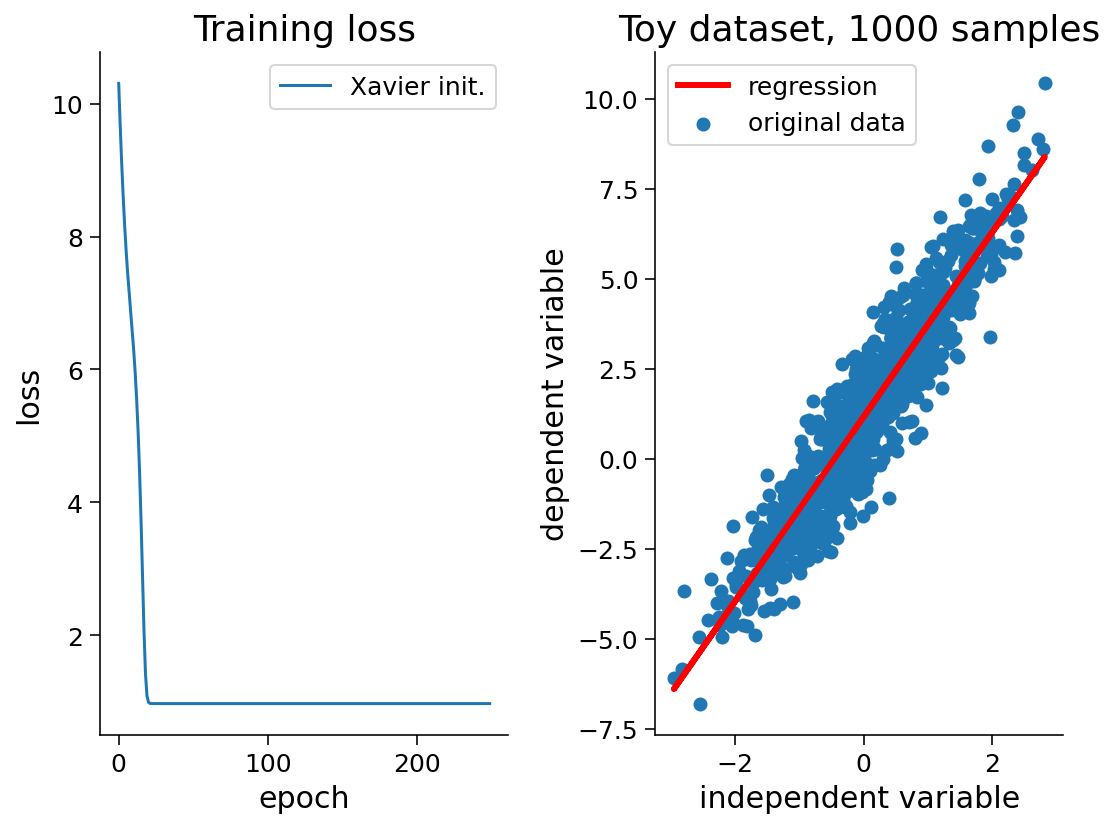

In [16]:
# Initialize networks well via Xavier technique


def deepNetwork(deep=False):
    # Network parameters
    input_dim = 1
    output_dim = 1

    if deep:
        h1, h2, h3, h4, h5, h6 = 20, 15, 10, 5, 4, 2
        # define our network
        net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.Linear(h1, h2),
            nn.Linear(h2, h3),
            nn.Linear(h3, h4),
            nn.Linear(h4, h5),
            nn.Linear(h5, h6),
            nn.Linear(h6, output_dim),
        )
    else:
        # define our network
        net = nn.Sequential(nn.Linear(input_dim, 1))

    # parameters initialization
    for i in range(len(net)):
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        # raise NotImplementedError("Scale with Xavier's method!")
        ####################################################################
        n_in = net[i].in_features  # or net[i].weight.shape[1]
        n_out = net[i].out_features  # or net[i].weight.shape[0]
        sigma = np.sqrt(6 / (n_in * n_out))
        net[i].weight.data.uniform_(-sigma, sigma)
        net[i].bias.data.uniform_(-sigma, sigma)

    return net


## uncomment the lines below to test your initialization (Xavier) method
net = deepNetwork(deep=True)
outputXav = training_loop(X, y, model=net)
plotRegression(X, y, outputXav[0], outputXav[1])


## Section 3.2: A simpler intialization


Video available at https://youtube.com/watch?v=XFHbvGXP1Ng


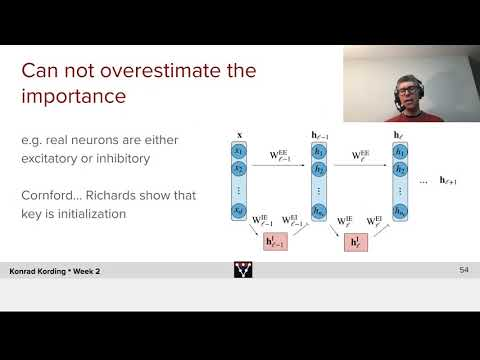

In [17]:
# @title Video: Xavier vs a simpler initialization

video = YouTubeVideo(id="XFHbvGXP1Ng", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


As we have seen, Xavier's initialization makes certain assumptions about the distribution of $\mathbf{x}$ and $\mathbf{g}$. It also involved averaging two constratins: one derived from desiderata on the forward pass, and one from the backwards pass.

Xavier's method (also known as Glorot initialization) is now standard in many deep learning libraries. In this section, we'll see if we can get away with a simpler method that only uses the constraint from the forward pass, which you may recall is $$\sigma_w \ \sqrt{1/n_{in}} \, .$$


### Exercise 4: Compare the simpler method with Xavier's technique

Use a simpler method to initialize the parameters. Let's scale with the width of the inputs, i.e., $\sigma_w=1/\sqrt{n_{in}}$.

_Clarification:_ Keep the bias at 0 in this exercise.


loss:   0%|          | 0/250 [00:00<?, ?it/s]

The loss after training is: 0.9738821983337402


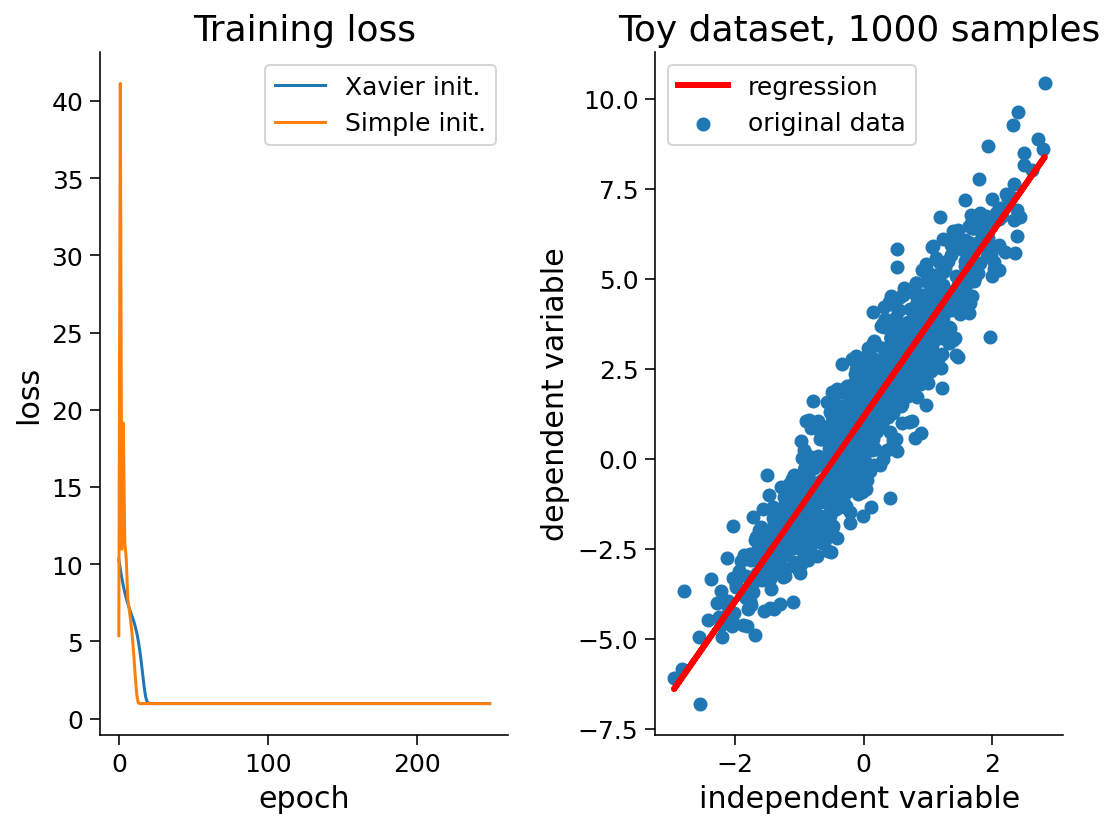

In [18]:
def deepNetwork(deep=False):
    # Network parameters
    input_dim = 1
    output_dim = 1

    if deep:
        h1, h2, h3, h4, h5, h6 = 20, 15, 10, 5, 4, 2
        # define our network
        net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.Linear(h1, h2),
            nn.Linear(h2, h3),
            nn.Linear(h3, h4),
            nn.Linear(h4, h5),
            nn.Linear(h5, h6),
            nn.Linear(h6, output_dim),
        )
    else:
        # define our network
        net = nn.Sequential(nn.Linear(input_dim, 1))

    # parameters initialization
    for i in range(len(net)):
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        #raise NotImplementedError("Scale weights w.r.t width!")
        ####################################################################
        n_in = net[i].weight.shape[1]
        sigma = 1 / np.sqrt(n_in)
        net[i].weight.data.normal_(0, sigma)
        net[i].bias.data.normal_(0, sigma)

    return net


## uncomment the lines below to test your initialization choice
net = deepNetwork(deep=True)
outputSimple = training_loop(X, y, model=net)
plotRegression(X, y, outputSimple[0], outputXav[1], outputSimple[1])


Both methods converge in the same set of parameters and at almost the same rate. However, this is not the case for more challenging tasks. This feature is critical in large scale applications, where the demand for speed is high.


---

# Section 4: How linear networks are not linear.

_Estimated time: 75 minutes since start_


Video available at https://youtube.com/watch?v=9qPwfWlAsOM


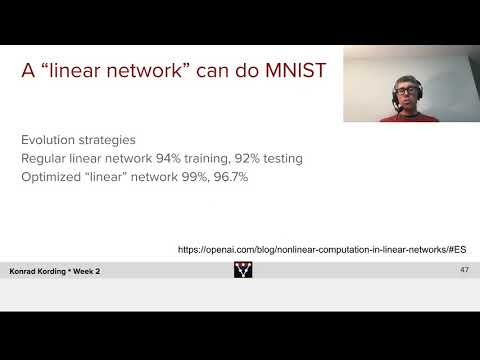

In [19]:
# @title Video: Solving XOR with Linear Neural Networks

try:
    t2
except NameError:
    t2 = time.time()

video = YouTubeVideo(id="9qPwfWlAsOM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


Here, we will show that one can use a linear NN (without any nonlinearity) and solve a nonlinear problem. We focus on the XOR problem, i.e., a logical operation with linear nonseparable data!

Exclusive OR (XOR) logical operation gives a true (`1`) output when the number of true inputs is odd. That is, a true output result if one, and only one, of the inputs to the gate is true. If both inputs are false (`0`) or both are true or false output results. Mathematically speaking, XOR represents the inequality function, i.e., the output is true if the inputs are not alike; otherwise, the output is false.

In case of two inputs ($X$ and $Y$) the following truth table is applied:

\begin{array}{ccc}
X & Y & \text{XOR} \\
\hline
0 & 0 & 0 \\
0 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 0 \\
\end{array}

Here, with `0`, we denote `False`, and with `1` we denote `True` in boolean terms.

But, how are we going to solve a linear nonseparable dataset without using a nonlinearity?

We will show that deep linear networks implemented using floating-point arithmetic are not actually linear and can perform nonlinear computation! Without any nonlinearity, consecutive linear layers would be, in theory, mathematically equivalent to a single linear layer. So, it is a surprise that floating-point arithmetic is nonlinear enough to yield deep trainable networks.

Numbers used by computers aren’t perfect mathematical numbers but approximate representations using finite numbers of bits. Computers commonly use _floating-point_ numbers to represent mathematical objects. Each _floating-point_ number is represented by a combination of a fraction and an exponent. In the IEEE’s float32 standard, 23 bits are used for the fraction and 8 for the exponent, and one for the sign. See more [here](https://openai.com/blog/nonlinear-computation-in-linear-networks/).

The linear network will consist of 3 layers; the input layer, a hidden layer, and the output layer.

First, we want to see if we can push the network in a regime where linear operations become non-linear. Thus, we construct a data set with $X$ and $Y$ variables in the range $[-1.1, 1.1]$.


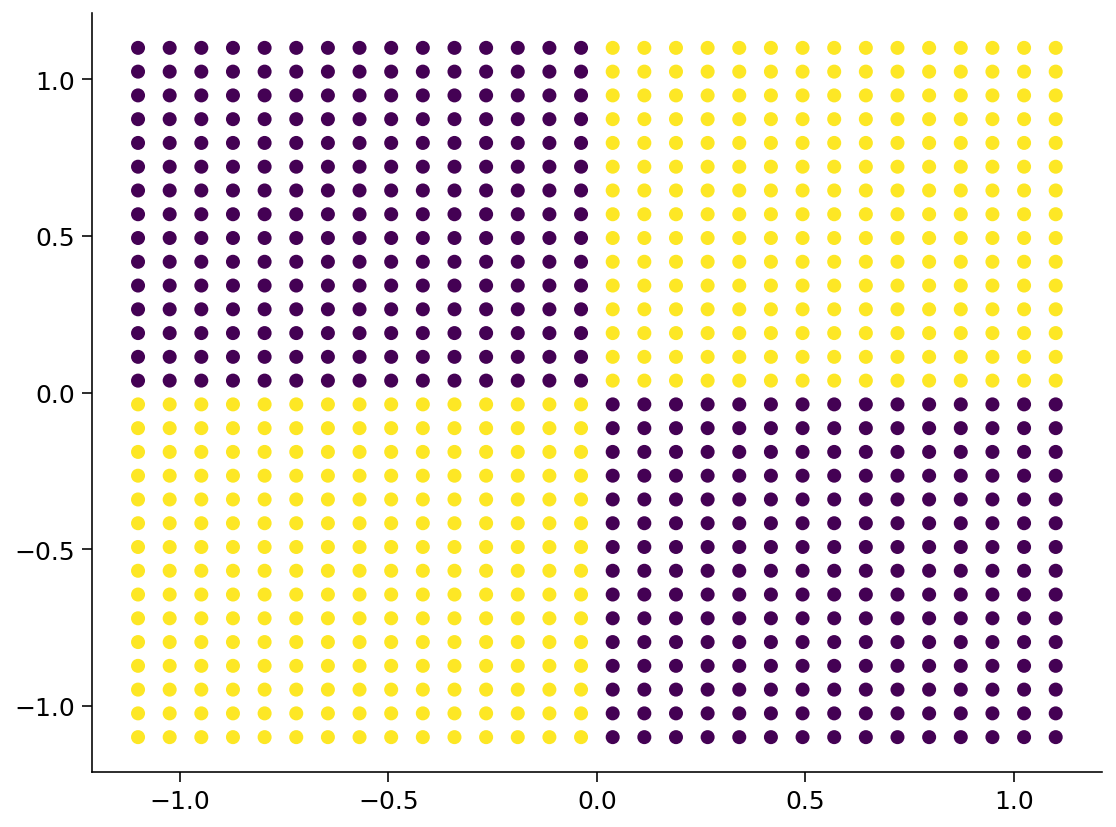

In [20]:
# enable denormals in pytorch to take advantage of the non-linear effects
torch.set_flush_denormal(True)

# generating the data set
X = np.linspace(start=-1.1, stop=1.1, num=30)
Y = np.linspace(start=-1.1, stop=1.1, num=30)

inputs = np.array(np.meshgrid(X, Y)).T.reshape(-1, 2)
targets = np.ones(shape=(900, 1))
targets[inputs[:, 0] * inputs[:, 1] < 0] = -1.0

inputs = inputs.astype(np.float32)
targets = targets.astype(np.float32)

# Convert inputs and targets to tensors
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

plt.figure()
plt.scatter(
    inputs.detach().cpu().numpy()[:, 0], inputs.detach().cpu().numpy()[:, 1], c=targets
)
plt.show()


Now, let's implement the linear network from scratch. We do this since it gives us better handling and because we are going to use a weird scaling operation! Recall that we will use a similar network to the one used for linear regression in Tutorial 1 (i.e., `linear_regression()` function).

```python
def mynetwork(x, params):

  w1, ..., b3 = params[0], ..., params[5]

  h1 = x @ w1.t() + b1  # dot product of inputs with weights and adding the bias
  h2 = h1 @ w2.t() + b2  # similarly
  return (h2 @ w3.t() + b3)  # similarly
```

Spend a minute to understand the network's implementation.

Let's initialize the parameters. Notice that we do not use learnable parameters (`requires_grad=False`) in the first layer. We initialize the weights close to zero. Notice that `torch.mul(input, other)` multiplies each element of the `input` with the scalar `other` and returns a new resulting tensor.


In [21]:
# Initial Weights and biases

input_dim = inputs.shape[1]
output_dim = targets.shape[1]
hidden1, hidden2 = 10, 1  # size of the hidden layers

w1 = Variable(
    torch.mul(torch.randn(hidden1, input_dim), np.sqrt(1 / input_dim)),
    requires_grad=False,
)
b1 = Variable(torch.mul(torch.randn(hidden1), 0.0), requires_grad=False)

w2 = Variable(
    torch.mul(torch.randn(hidden2, hidden1), np.sqrt(1 / hidden1)), requires_grad=True
)
b2 = Variable(torch.mul(torch.randn(hidden2), 0.0), requires_grad=True)

params = [w1, b1, w2, b2]


## Define a 'crazy' scaling and plot the output of the hidden layer

We have to scale down weights and biases to very small (i.e., tiny) values to exploit the nonlinearity. In this regime (i.e., tiny numbers) the common rules of mathematics stop applying. But why is this true? Let's see a small example.

Assume that we have three numbers, $\alpha$, $\beta$, and $\gamma$ and $scale$ is a very large number, close to the machine's maximum number (e.g., $scale = 2^{126})$.


In [22]:
def mathematics(scale):
    a = 1.5 * (1 / scale)
    b = -1.2 * (1 / scale)
    c = 1.0 * (scale)

    sum1 = (a + b) * c
    sum2 = a * c + b * c

    print(f"(a + b)c = {sum1} and ac + bc = {sum2}")


scale_high = torch.tensor(2**110, dtype=torch.float32)
scale_low = torch.tensor(2**126, dtype=torch.float32)


mathematics(scale_high)
mathematics(scale_low)


(a + b)c = 0.2999999523162842 and ac + bc = 0.2999999523162842
(a + b)c = 0.0 and ac + bc = 0.2999999523162842


As you see, going down to tiny values, the mathematical expression does not hold. Let's see this interesting effect in action. Back to XOR problem!


Now, we try different values to verify that the network is linear, apart from a range of values where the scaling is very large, and the network is behaving as a nonlinear one.


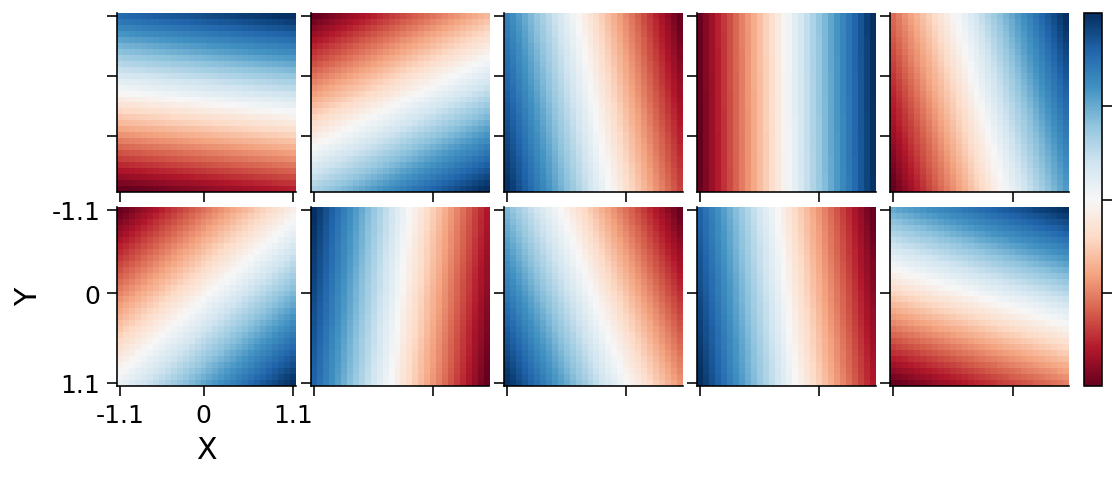

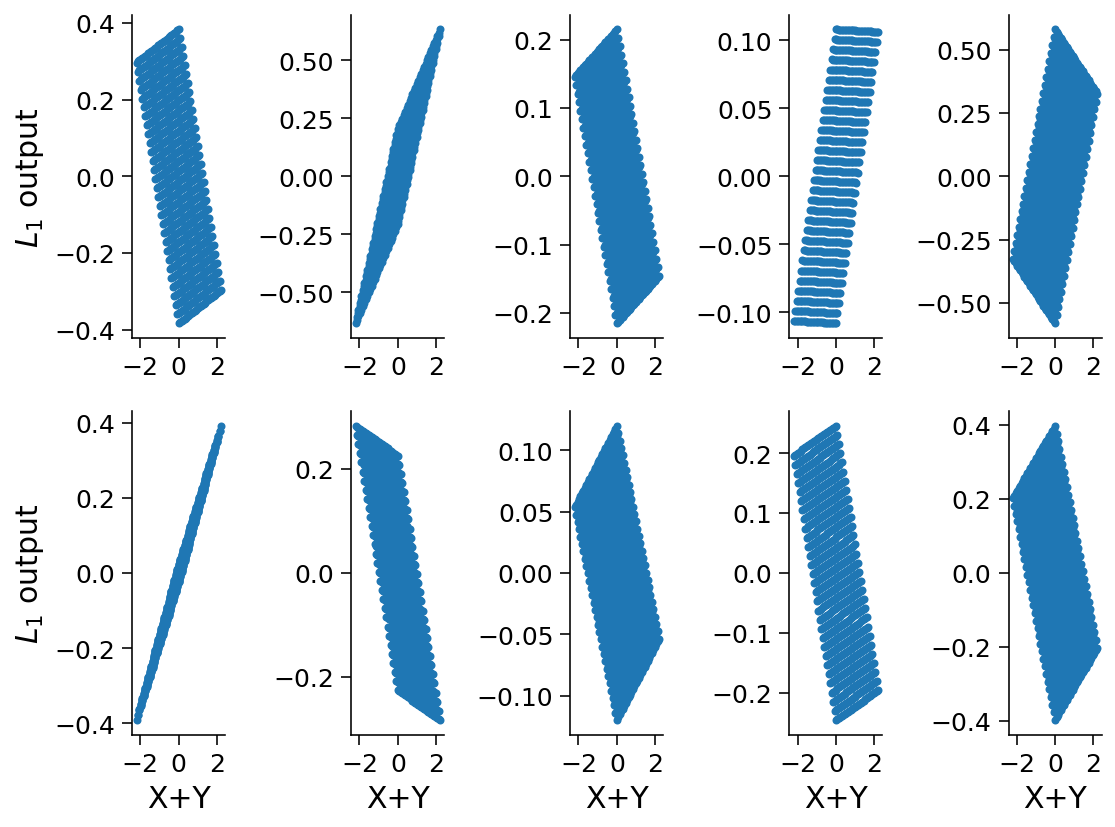

In [23]:
# Not a 'Crazy scaling'

# Define the model - custom based to have better handling
def model(x, params, scaling):

    w1, b1, w2, b2 = params[0], params[1], params[2], params[3]
    h1 = x @ w1.t() / scaling + b1 / scaling
    out = (h1 @ w2.t() + b2 / scaling) * scaling
    return out, h1


scaling = torch.tensor(2**2, dtype=torch.float32)
out = model(inputs, params, scaling)
activ_l1 = out[1]
warnings.filterwarnings("ignore")  # To reactivate wornings: filterwarnings("default")
XOR_plots(activ_l1)


So, what we see here is at the top panel, the heatmap of the output of the first layer (i.e., the colors represent the output) as a function of the given set of inputs, $X$, $Y$. Things here are linear. You can see this from the bottom plot, where the output is plotted as a function of the summed inputs, $X+Y$.

Let's try a way larger scaling value. What about $2^{124}$?


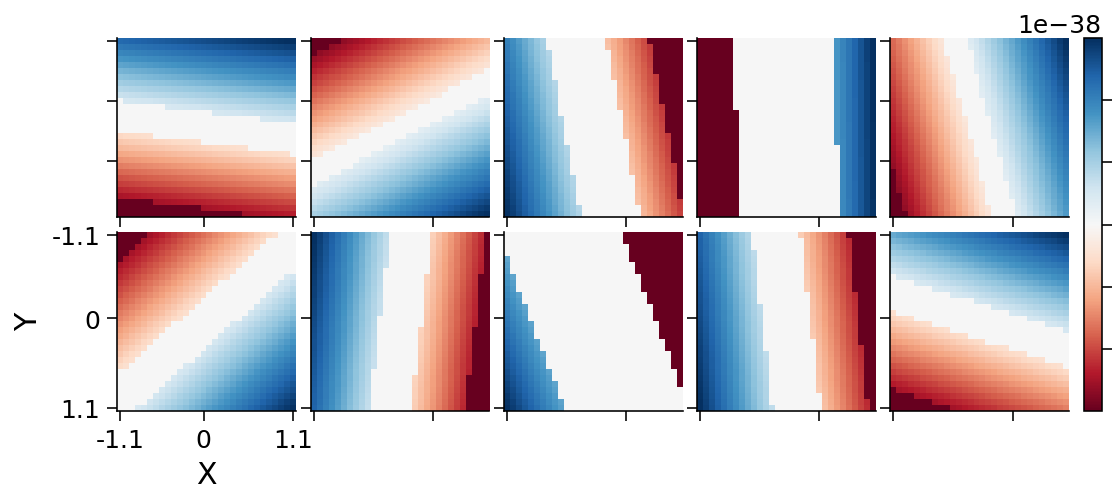

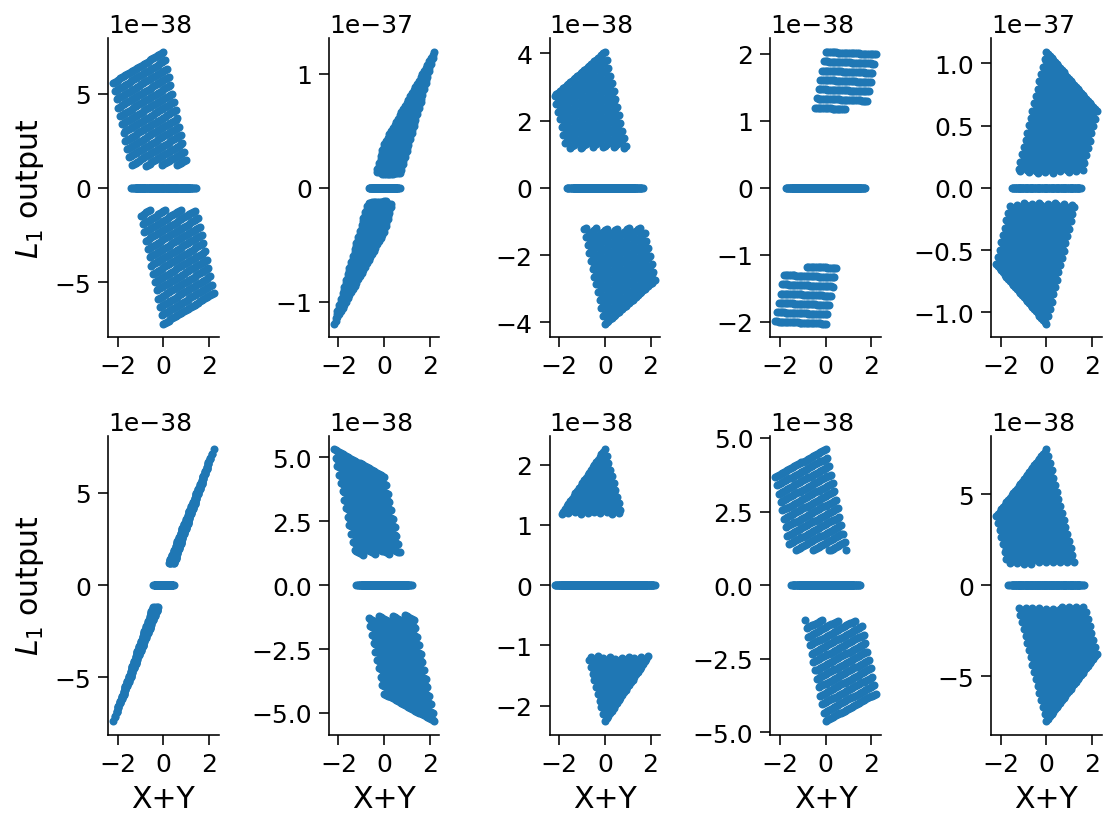

In [24]:
# A 'Crazy scaling'
scaling = torch.tensor(2**124, dtype=torch.float32)
out = model(inputs, params, scaling)
warnings.filterwarnings("ignore")  # To reactivate wornings: filterwarnings("default")
XOR_plots(out[1])


Ok, now the neurons behave nonlinearly!


How can we push the network to operate in a nonlinear regime using the binary inputs to solve XOR? First, we construct the dataset consisting of $4$ input vectors and four target values, given in the table above.


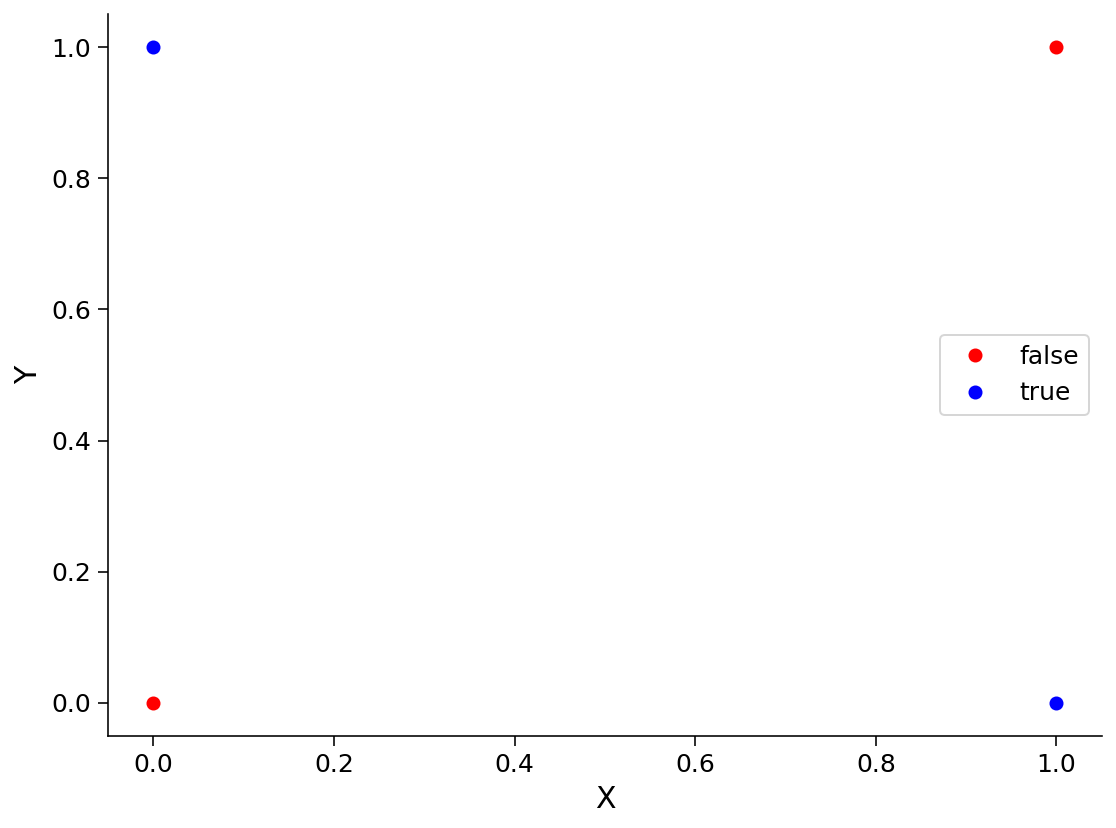

X, Y: 
[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
XOR: 
[[0.]
 [1.]
 [1.]
 [0.]]


In [25]:
# Construct the input data
inputs = np.array([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]])
targets = np.array([[0.0], [1.0], [1.0], [0.0]])

plt.figure()
plt.plot(inputs[0, 0], inputs[0, 1], "r.", markersize=12.0, label="false")
plt.plot(inputs[3, 0], inputs[3, 1], "r.", markersize=12.0)
plt.plot(inputs[1, 0], inputs[1, 1], "b.", markersize=12.0, label="true")
plt.plot(inputs[2, 0], inputs[2, 1], "b.", markersize=12.0)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

print(f"X, Y: \n{inputs}")
print(f"XOR: \n{targets}")

# set the input in float32 type
inputs = inputs.astype(np.float32)
targets = targets.astype(np.float32)

# Convert inputs and targets to tensors
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)


## Solve XOR logical operation

To take advantage of the kicked-in nonlinearity, inspect carefully the plots above and choose the bias to move close to the emerging nonlinearity to $[0,1]$ range.

Here, by having 1000 neurons in the first layer and setting the bias to sampled from a gaussian with a large standard deviation, i.e., $\sigma=2$, we force some of the nodes to operate in the non-linear regime.


In [26]:
# Show how a deep linear network can 'wrongly' solve xor


def solveXOR(inputs, targets, scaling, seed=2021):

    # Network dimensions
    input_dim = inputs.shape[1]
    output_dim = targets.shape[1]
    hidden1, hidden2 = 1000, 1

    # Initial Weights and biases
    torch.manual_seed(seed)
    w1 = Variable(
        torch.mul(torch.randn(hidden1, input_dim), np.sqrt(1 / input_dim)),
        requires_grad=False,
    )
    b1 = Variable(torch.mul(torch.randn(hidden1), 2.0), requires_grad=False)

    w2 = Variable(
        torch.mul(torch.randn(hidden2, hidden1), np.sqrt(1 / hidden1)),
        requires_grad=True,
    )
    b2 = Variable(torch.mul(torch.randn(hidden2), 1.0), requires_grad=True)

    params = [w1, b1, w2, b2]

    # Training loop parameters
    lr = 2e-4  # learning rate
    epochs = 250  # total epochs
    criterion = nn.MSELoss()  # loss function

    # Train for epochs
    losses = []

    epoch_range = trange(epochs, desc="loss: ", leave=True)

    for epoch in epoch_range:
        if losses:
            epoch_range.set_description("loss: {:.6f}".format(losses[-1]))
            epoch_range.refresh()  # to show immediately the update
        time.sleep(0.01)

        out = model(inputs, params, scaling)
        loss = criterion(out[0], targets)
        loss.backward()

        # Adjust weights & reset gradients
        with torch.no_grad():
            # Gradient descent
            w2 -= w2.grad * lr
            b2 -= b2.grad * lr
            # flush gradients
            w2.grad.zero_()
            b2.grad.zero_()

        losses.append(loss)

    # make the predictions
    return (model(inputs, params, scaling), b1)


outputs = solveXOR(inputs, targets, scaling)
XORpredictions(
    inputs.cpu().detach().numpy(),
    targets.cpu().detach().numpy(),
    outputs[0][0].cpu().detach().numpy(),
)


loss:   0%|          | 0/250 [00:00<?, ?it/s]


Test the model on XOR logical operation...
Input:[0,0] Target:[0] Predicted:[0.0] Error:[0.0]
Input:[0,1] Target:[1] Predicted:[1.0224] Error:[0.0224]
Input:[1,0] Target:[1] Predicted:[1.102] Error:[0.102]
Input:[1,1] Target:[0] Predicted:[-0.0] Error:[0.0]


Hooray! You have solved XOR with a pure Linear Neural Network!


---

# Section 5: Race ideas (first components increase exponentially)

_Estimated time: 105 minutes since start_


Video available at https://youtube.com/watch?v=c3VNOmbi1tU


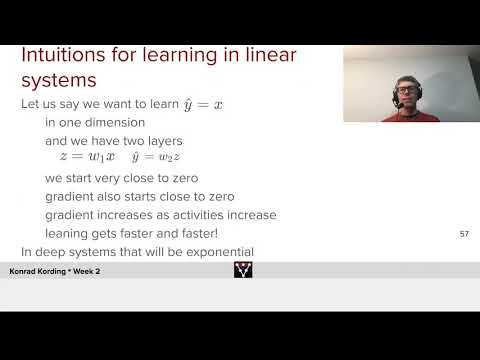

In [27]:
# @title Video: Accelerating Growth
import time

try:
    t5
except NameError:
    t5 = time.time()

video = YouTubeVideo(id="c3VNOmbi1tU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


## Section 5.1: 1-Dimension scenario

So, let's take the simplest case, where we have a linear network with multiple layers but only one neuron (i.e., node) per layer. Initializing the weight close to zero, i.e., sampling from a normal distribution with a small $\sigma$, we can observe when our network starts learning.

Towards this goal, we will plot the weights against epochs, and what we expect is to see the weights changing rapidly at some point (i.e., epoch). If the network has learned the task, the weights will remain unchanged, which means that the gradients are almost zero, so the model has been converged.


In [28]:
# 1D data
original_w = torch.tensor([2.5]).reshape(-1, 1)
original_b = 1.2
N = 1000  # number of examples
inputs, targets = synthetic_dataset(
    original_w, original_b, num_examples=1000, sigma=0.1
)
inputs = inputs.T
print(inputs.shape, targets.shape)


torch.Size([1000, 1]) torch.Size([1000, 1])


We build a model with two, one dimensional (i.e., one node) hidden layers.


In [29]:
# Define the model
def network(input_dim, output_dim, hidden_sizes):

    # define our network
    net = nn.Sequential(
        nn.Linear(input_dim, hidden_sizes),
        nn.Linear(hidden_sizes, hidden_sizes),
        nn.Linear(hidden_sizes, output_dim),
    )

    # parameters initialization
    for i in range(len(net)):
        sigma = 1e-1
        net[i].weight.data.normal_(0, sigma)
        net[i].bias.data.fill_(0)

    return net


loss:   0%|          | 0/1000 [00:00<?, ?it/s]

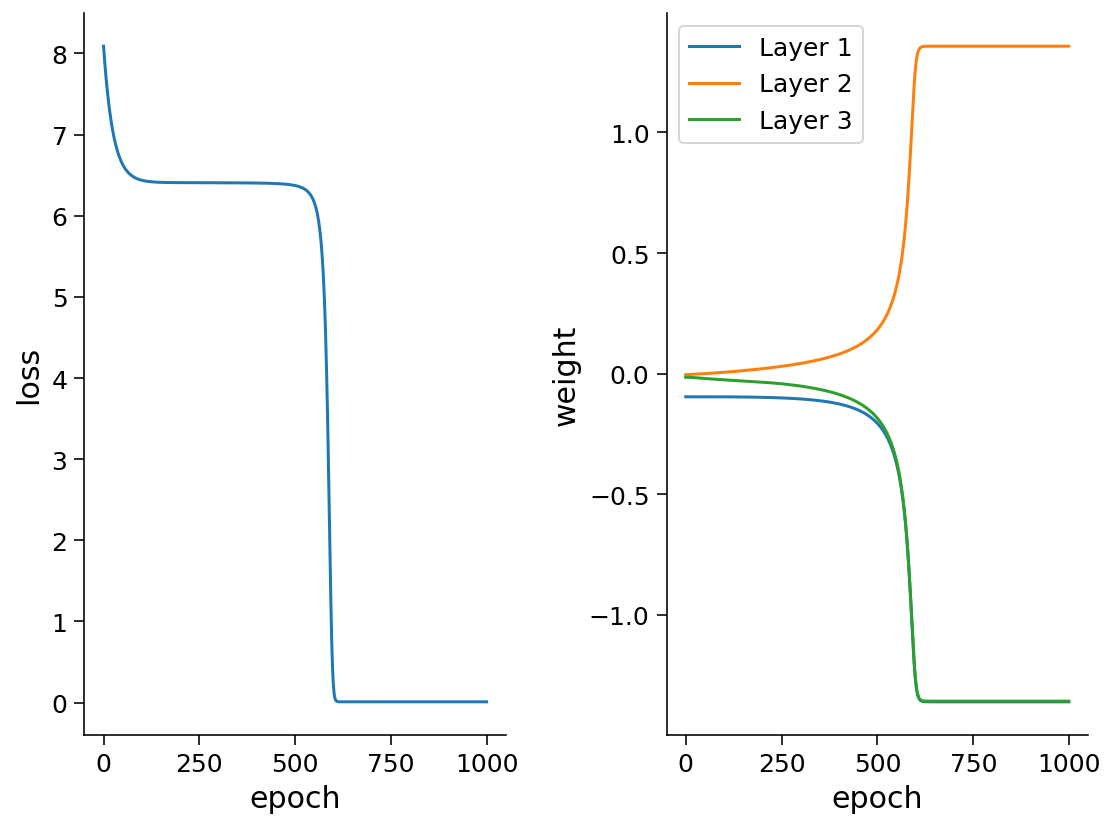

In [30]:
def training_1d(inputs, targets):

    input_dim = inputs.shape[1]
    output_dim = targets.shape[1]
    hidden_sizes = 1

    learning_rate = 1e-2  # learning rate
    num_epochs = 1000

    # Loss function
    criterion = nn.MSELoss()

    model = network(input_dim, output_dim, hidden_sizes)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    # Train for num_epochs
    losses = []
    weights = np.empty((len(model), num_epochs))

    # this few lines would implement a progress bar and loss description
    epoch_range = trange(num_epochs, desc="loss: ", leave=True)
    for epoch in epoch_range:
        if losses:
            epoch_range.set_description("loss: {:.6f}".format(losses[-1]))
            epoch_range.refresh()  # to show immediately the update
        time.sleep(0.01)

        preds = model(inputs)

        loss = criterion(preds, targets)
        loss.backward()

        # Store the weights
        for j in range(len(model)):
            weights[j, epoch] = model[j].weight.detach().numpy()

        # Grdient descent
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.item())

    return (losses, weights, num_epochs)


output = training_1d(inputs, targets)
losses = output[0]
weights = output[1]
plot_weight(losses, weights)


As we see here, the loss plot has two distinct phases; a drop, then unchanged, and then a huge drop to its steady-state. If we see the weights' plots, in the beginning, learning has not started, and then the absolute value of weights is increased exponentially until convergence. This kind of plot demonstrates the learning dynamics of our simple linear network.

Now, it's time to increase the dimensions of both the input and output!


## Section 5.2: Multiple Dimensions


Video available at https://youtube.com/watch?v=MrqLuBsVtWU


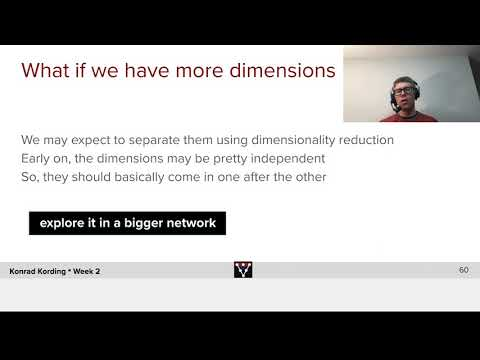

In [31]:
# @title Video: How Multiple Dimensions Kick In

video = YouTubeVideo(id="MrqLuBsVtWU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


Here, we go deeper into understanding the learning dynamics. As we have shown in the previous examples, a linear neural network can learn a set of parameters to perform linear regression.

The idea behind this approach is to find an input-output relationship of a linear neural network. Thus, we want to take into account the weight matrix product, i.e., $W_{[1]}^{\text{T}}W_{[2]}^{\text{T}} \dots W_{[L]}^{\text{T}}$, where $L$ denotes the number of layers in our network.

Towards understanding the learning dynamics, we decompose the weight matrix product into orthogonal vectors and then keep track of the singular values across time evolution, i.e., epochs.

From Linear Algebra, we know that we can decompose any matrix $A$ into two orthogonal matrices and one diagonal matrix with the relationship:

\begin{equation}
A = UΣV^{\text{T}}
\end{equation}

Here, we perform the so-called singular value decomposition (SVD) in every epoch's weight matrix product. For a refresher, see this [tutorial](http://gregorygundersen.com/blog/2018/12/10/svd/#:~:text=The%20singular%20value%20decomposition%20or,that%20build%20on%20the%20SVD.).

We store the first $k$ singular values, and then we plot them against epochs.

This approach's intuition is that we want to know how much a column of the weight product matrix is learned over time. That is, what is the size of the learned $W_{[1]}^{\text{T}}W_{[2]}^{\text{T}}$ projected onto that column, i.e., the corresponding singular value.

To better illustrate this idea, we will use synthetic data in high dimensions. Here, our independent variables, $x$ are in the $100D$ space, whereas the dependent ones $y$, are in $10D$ space.

If the dependent variable lies in the $2D$ space and above, the method is also called **multivariate linear regression**.

Notice that our data $\textbf{X} \in \mathbb{R}^{N \times D}$, where $N$ is the number of examples, and $D$ the number of features.


In [32]:
# More dimensions; Start with some random original weights.
original_w = torch.randn((100, 10))
original_b = 1.2
N = 1000  # number of examples
X, y = synthetic_dataset(original_w, original_b, num_examples=N, sigma=0.1, seed=2021)

# We take the transpose matrices
inputs = X.T
targets = y.T

print(f"input size is: {inputs.shape}," f"target size is: {targets.shape}")


input size is: torch.Size([1000, 100]),target size is: torch.Size([1000, 10])


Here, we use a network with one hidden layer, but you can extend this adding more layers to the network.


In [33]:
# Define the model
def networkSVD(input_dim, output_dim, hidden_sizes):

    # define our network
    net = nn.Sequential(
        nn.Linear(input_dim, hidden_sizes), nn.Linear(hidden_sizes, output_dim)
    )

    # parameters initialization
    for i in range(len(net)):
        sigma = 1e-2
        net[i].weight.data.normal_(0, sigma)
        net[i].bias.data.fill_(0)

    return net


### Exercise 5: Compute the learning modes via SVD

Here, you have to apply the Singular Value Decomposition method to the weight product matrix. Recall from the previous tutorial that we need to `.detach().numpy()` the product matrix to be used in NumPy, where we perform a static operation.

_Hint:_ To compute SVD, you can use `np.linalg.svd`. See the documentation of this function by running on a scratch cell `? np.linalg.svd`. As you want to store the singular values only, we can enable the option `compute_uv=False`.


loss:   0%|          | 0/3000 [00:00<?, ?it/s]

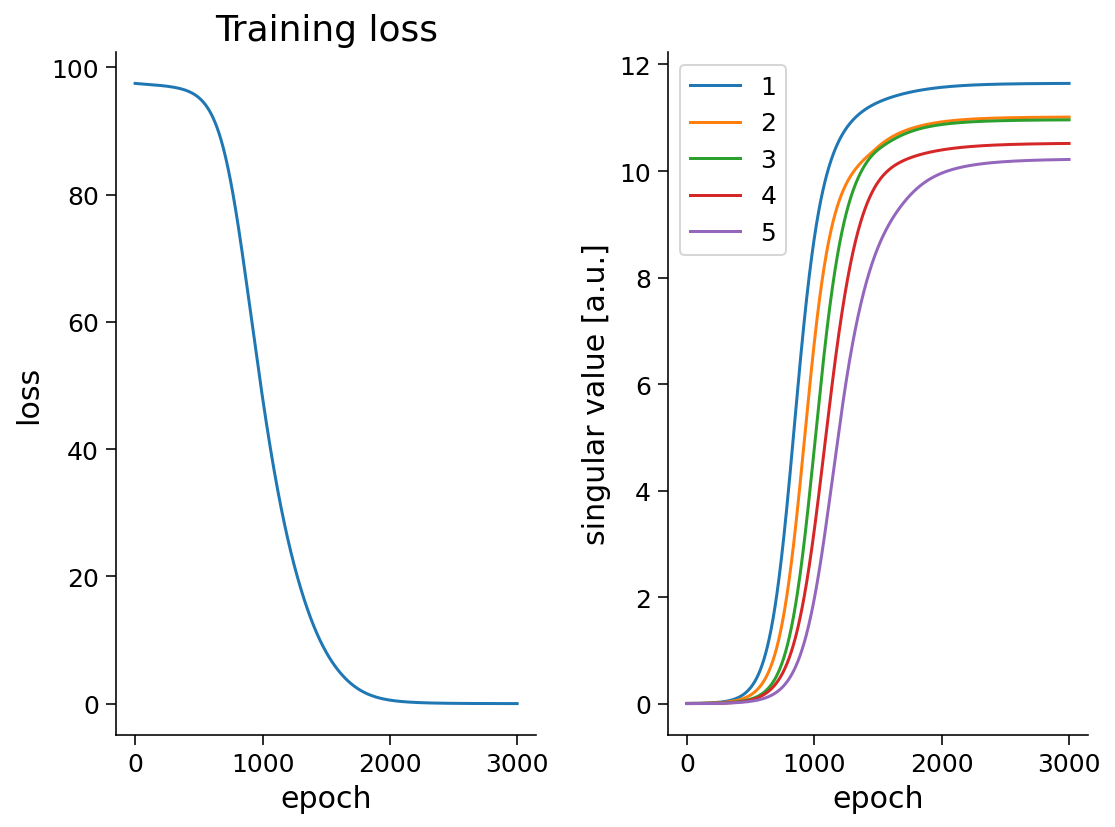

In [34]:
def training_modes(inputs, targets):

    input_dim = inputs.shape[1]
    output_dim = targets.shape[1]
    hidden_sizes = 20

    learning_rate = 2e-3  # learning rate
    num_epochs = 3000

    # Loss function
    criterion = nn.MSELoss()

    model = networkSVD(input_dim, output_dim, hidden_sizes)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Train for num_epochs
    losses = []
    rank = 5
    modes = np.empty((rank, num_epochs))

    # this few lines would implement a progress bar and loss description
    epoch_range = trange(num_epochs, desc="loss: ", leave=True)
    for epoch in epoch_range:
        if losses:
            epoch_range.set_description("loss: {:.6f}".format(losses[-1]))
            epoch_range.refresh()  # to show immediately the update
        time.sleep(0.01)

        preds = model(inputs)

        loss = criterion(preds, targets)
        loss.backward()

        # SVD applied on the matrix product
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        #raise NotImplementedError("Calculate w1.T*w2.T, detach, and then apply SVD")
        ####################################################################
        w_mult = model[0].weight.data.T @ model[1].weight.data.T
        w_svd = np.linalg.svd(w_mult, compute_uv=False)
        modes[:, epoch] = w_svd[:rank]

        # Grdient descent
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.item())

    return (losses, modes, num_epochs)


# uncomment the lines below to test your SVD method
output = training_modes(inputs, targets)
plot_learning_modes(output[0], output[2], output[1], rank=5)


As we see from the loss plot, our networks initially learn very slowly, and then the first learning component exponentially increases, which means fast learning. After a phase where the learning curve is almost constant with respect to epochs, the rest of the components increase exponentially, which explains our model's convergence.

Of course, we can use more complex approaches to retrieve the learning components (e.g., using [`tensorly`](http://tensorly.org/stable/auto_examples/index.html#tensor-decomposition) or [`tensortools`](https://tensortools-docs.readthedocs.io/en/latest/)). These tools perform tensor decompositions (similar to SVD approach but applied on $3D$ tensors).


---

# Section 6: Cost functions - how problems give rise to cost functions


Video available at https://youtube.com/watch?v=O8psSHspno0


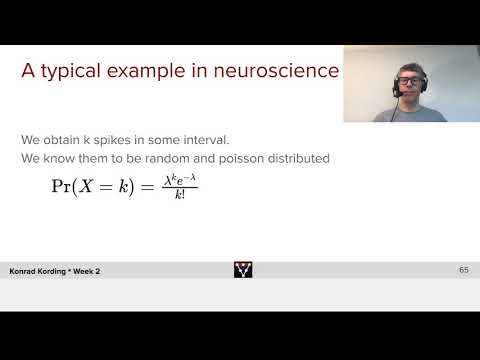

In [35]:
# @title Video: LogP as a Cost Function

try:
    t6
except NameError:
    t6 = time.time()

video = YouTubeVideo(id="O8psSHspno0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


## Section 6.1: MSE, where is MSE good? Statistical properties of MSE estimators.

As we already defined previously, in linear regression models, a common cost function is the so-called **Mean Squared Error (MSE)**. This cost function is also known as _Quadratic Loss_, as the function is of a quadratic form, and _L2 Loss_ because the squared errors are of the same form as the L2 norm of a vector. As a quadratic function, the range of MSE is from $0$ to $\infty$.

Here, we more formally motivate the MSE cost function using assumptions about the distribution of additive noise in our dataset. As we show in the previous tutorial, the MSE in a dataset $\textbf{X}$ is given by:

\begin{align}
L(\mathbf{w}, b) &{} = \frac{1}{N} \sum*{i=1}^{N} \left( \hat{y}^{[i]} - y^{[i]}\right)^2 \\
&{}= \frac{1}{N} \sum*{i=1}^{N} \left(\mathbf{w}^{\text{T}} \mathbf{x}^{[i]} + b - y^{[i]}\right)^{2}.
\end{align}

One way to motivate linear regression with the mean squared error loss function, i.e., $L(\mathbf{w}, b)$, is to formally assume that observations arise from noisy observations, where the noise is normally distributed (see W2 Part 1):

\begin{equation}
y = \textbf{w}^T\textbf{x} + b + \epsilon, \epsilon \sim \mathcal{N}(\mu=0, \sigma)
\end{equation}

Therefore, we can write the _likelihood_ of seeing a particular example $y$ given the independent variable $\mathbf{x}$

\begin{equation}
p(y|\mathbf{x}) = \frac{1}{2\pi\sigma^2} \text{exp}\left( -\frac{1}{2\sigma^2} \left( \mathbf{w}^T\mathbf{x} + b - y \right)^2 \right)
\end{equation}

Assuming that all values in our dataset are independent and identically distributed (i.i.d.), the total likelihood of our dtaset is given by:

\begin{equation}
P(\mathbf{y}|\mathbf{X}) = \prod\_{n=1}^N p\left(y^{[i]}|\mathbf{x}^{[i]} \right)
\end{equation}

According to the maximum likelihood principle, the best values of parameters $\mathbf{w}$ and $b$ are those that maximize the likelihood of the entire dataset (i.e., _maximum likelihood estimators_).

While maximizing the product of many exponential functions might look difficult, we can simplify things significantly, without changing the objective, by maximizing the log of the likelihood instead. For historical reasons, optimizations are more often expressed as minimization rather than maximization. So, without changing anything, we can minimize the negative log-likelihood

\begin{equation}
-\text{log} P(\mathbf{y}|\mathbf{X}) = -\text{log} \left( \prod\_{n=1}^N p\left(y^{[i]}|\mathbf{x}^{[i]} \right) \right)
\end{equation}

Using the logarithm property states that the logarithm of a product is the sum of the logarithms of the individual components being multiplied, i.e., $\text{log}(a \cdot b) = \text{log}(a) + \text{log}(b)$, thus the log-likelihood is given by:

\begin{align}
-\text{log} P(\mathbf{y}|\mathbf{X}) &{}= -\text{log} \left( \prod*{n=1}^N p\left(y^{[i]}|\mathbf{x}^{[i]} \right) \right) \\
&{}= -\sum*{n=1}^N \text{log}\left( p\left(y^{[i]}|\mathbf{x}^{[i]} \right) \right) \\
&{} = \sum\_{i=2}^N \left( \frac{1}{2}\text{log}(2\pi\sigma^2) + \frac{1}{2\sigma^2} \left( \mathbf{w}^T\mathbf{x}^{[i]} + b - y^{[i]} \right)^2 \right).
\end{align}

Assuming that $\sigma$ is constant for all examples, the minimization of the negative _log-likelihood_ with respect to the parameters $\textbf{w}$ and $b$ can be reduced by removing the left order of the summation. The remaining order is the squared loss (taking out the constant $\frac{1}{2\sigma^2}$. In other words, minimizing the **mean squared error** is equivalent to **maximum likelihood estimation** of a linear model under the assumption of additive Gaussian noise with constant variance ($\sigma^2$).


### Section 6.1.1 Download and Visualize the dataset

Here, we will use neural data (i.e., firing rates) of hundreds of neurons as independent variables (i.e., $\textbf{X}$). We aim to decode the reaching angle (i.e., $\textbf{Y}$) concerning the neurons' firing rates. For more info on the behavioral experiment, see [Flint et al., 2012](http://doi.org/10.1088/1741-2560/9/4/046006)

First, we will download the data. The data are extracted in 2 different groups:

1. **training data** for the model fitting
2. **testing (or test) data** for estimating the model’s performance

Why do we need to split our dataset?

In the real world, datasets contain both random and natural (i.e., real) effects. Hence it is unlikely to have a model that is 100% accurate. Furthermore, new data points will likely include random effects. Thus whether the model can explain these effects is subject to randomness. As a result, some random effects may be explained, while others may not.

We want to answer questions as simple as, "is my model good” and “how good is my model?”.

To answer these simple questions, we have to test our model in the most realistic scenario. It seems intuitive to split data into a training portion and a test portion, so the model can be trained on the first and then tested with the testing data. It may be a good idea to split the data so that the model can be **trained on a larger portion** to adapt to possible data structures. A typical process is to use $2/3$ of our data to train our model and test the rest $1/3$ of the dataset. Here, we have used a $90-10$ splitting for the illustration of the test set results.

Later in the course, you will learn about more sophisticated techniques in order not only to verify if your model is good but also to choose the best model among others.

Ok! Let's see what is downloaded:

1. `x_train`, `x_test`: independent variables, i.e., neuronal firing rates.
2. `y_train`, `y_test`: target variable, i.e., reaching angle.


In [36]:
DATA = getData()

x_train = DATA[0]
y_train = DATA[1]
x_test = DATA[2]
y_test = DATA[3]


  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


HDF5ExtError: ignored

Let's now see how some sample examples look like and plot a histogram of the reaching angles.


NameError: ignored

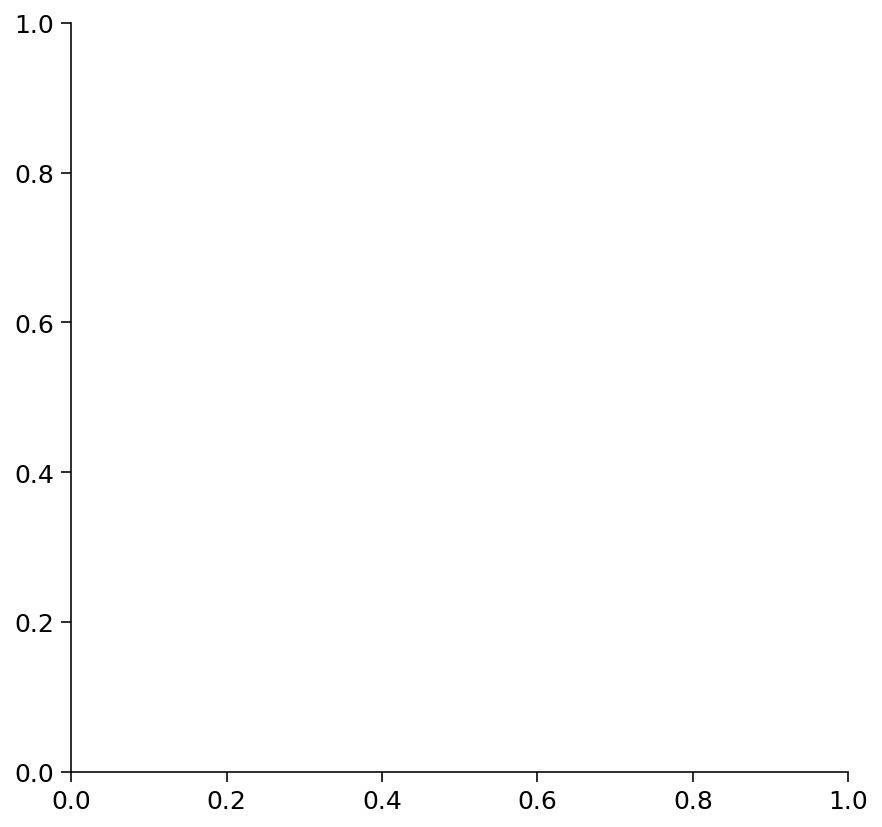

In [50]:
neuron_id = [1, 30, 40]  # plot some neurons!

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for id in neuron_id:
    plt.plot(x_train[id, :], label=f"neuron {id}")
plt.xlabel("time bin")
plt.ylabel("spikes/sec")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(y_train, bins=15, density=True)
plt.ylabel("probability density")
plt.xlabel("reaching angle (radians)")
plt.xlim([-1.4 * np.pi, 1.4 * np.pi])
plt.show()


### Section 6.1.2 Construct the model using `nn.Module`


In [ ]:
# Model
class SimpleNet(nn.Module):
    # Initialize the layers
    def __init__(self, input_dim, hidden_units, output_dim):
        super().__init__()

        self.layers = nn.ModuleList()
        self.hidden_units = hidden_units

        # A fully-connected network (FCN) with len(hidden_units) hidden layers
        for i in range(len(hidden_units)):
            self.layers += [nn.Linear(input_dim, self.hidden_units[i])]
            input_dim = self.hidden_units[i]

        self.out = nn.Linear(input_dim, output_dim)

    # forward pass
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return self.out(x)


model = SimpleNet(input_dim=219, hidden_units=[50, 25, 10], output_dim=1)
print(model)


### Section 6.1.3 Train the model


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Converting inputs and labels to Variable
if torch.cuda.is_available():
    inputs = Variable(torch.from_numpy(x_train).float().cuda())
    targets = Variable(torch.from_numpy(y_train).float().cuda())
    inputs_test = Variable(torch.from_numpy(x_test).float().cuda())
    targets_test = Variable(torch.from_numpy(y_test).float().cuda())
else:
    inputs = Variable(torch.from_numpy(x_train).float())
    targets = Variable(torch.from_numpy(y_train).float())
    inputs_test = Variable(torch.from_numpy(x_test).float())
    targets_test = Variable(torch.from_numpy(y_test).float())

# input size dimension - features
input_dim = inputs.shape[1]
output_dim = targets.shape[1]
# size of the hidden layer
hidden = [50, 10]

learningRate = 1e-4
epochs = 500

model = SimpleNet(input_dim, hidden, output_dim)

# Make it run on GPU!
model.train(True)
model.to(device)

# Loss function
criterion = nn.MSELoss()
# Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

loss_val = []
loss_test = []

epoch_range = trange(epochs, desc="loss: ", leave=True)
for epoch in epoch_range:
    if loss_val:
        epoch_range.set_description("loss: {:.6f}".format(loss_val[-1]))
        epoch_range.refresh()  # to show immediately the update
    time.sleep(0.01)

    # Clear gradient buffers because we don't want any gradient from
    # previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()
    # get output from the model, given the inputs
    outputs = model(inputs)
    # get loss for the predicted output
    loss = criterion(outputs, targets)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()
    loss_val.append(loss.item())
    # calculate and store the loss on the test set
    loss_test.append(criterion(model(inputs_test), targets_test))

plt.figure()
plt.plot(loss_val, label="training error")
plt.plot(loss_test, label="test error")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xlim(0, 100)
plt.legend()
plt.show()


### Section 6.1.4 Test the model


In [ ]:
# Testing the model

yhat_test = model(inputs_test)
loss_test = criterion(yhat_test, targets_test)
print(f"Loss in the test set: {loss_test}")

reaching_test(x_test, y_test, yhat_test)


## Section 6.2: Mean Absolute Error (MAE)


Video available at https://youtube.com/watch?v=jxp5faHAZgM


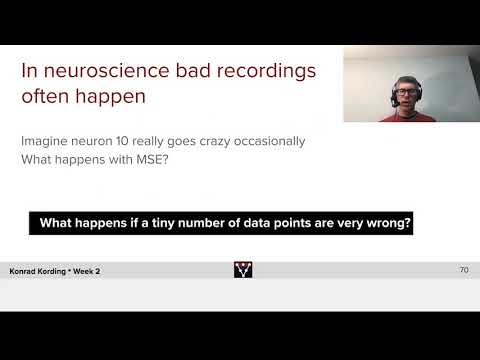

In [51]:
# @title Video: Outliers in Neural Activities

video = YouTubeVideo(id="jxp5faHAZgM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


Mean Absolute Error (MAE) is another loss function used for regression models. MAE is the sum of absolute differences between our target and predicted variables. So, it measures the average magnitude of errors in a set of predictions without considering their directions. Similarly, the range of MAE is from $0$ to $\infty$. MAE is also referred to as _L1 Loss_.

The mathematical description of MAE is given by:

\begin{align}
L(\mathbf{w}, b) &{} = \frac{1}{N} \sum*{i=1}^{N} \left| \hat{y}^{[i]} - y^{[i]}\right| \\
&{}= \frac{1}{N} \sum*{i=1}^{N} \left| \mathbf{w}^{\text{T}} \mathbf{x}^{[i]} + b - y^{[i]}\right|.
\end{align}


### Section 6.2.1 MSE vs. MAE (L2 Loss vs. L1 Loss)

In short, using the squared error is easier to solve, but using the absolute error is more robust to outliers. But let’s understand why!
Whenever we train a machine learning model, our goal is to find the point that minimizes loss function. Of course, both functions reach the minimum when the prediction is exactly equal to the true value.

Since MSE squares the error $l = \left( \hat{y} - y \right)^2$, the value of error ($l$) increases quickly if $l > 1$. If we have an outlier in our data, the value of $l$ will be high and $l^2$ will be $>> |l|$. This will make the model with MSE loss to weight more the outliers comparing with a model containing MAE as a loss function.

MAE loss is useful if the training data is corrupted with outliers (i.e., we erroneously receive unrealistically huge negative/positive values in our training environment, but not our testing environment).

Intuitively, we can think about it like this: If we only had to give one prediction for all the observations that try to minimize MSE, then that prediction should be the **mean** of all target values. However, if we try to minimize MAE, that prediction would be the **median** of all examples. We know that the median is more robust to outliers than mean, making MAE more robust to outliers than MSE.

One big problem in using MAE loss (especially in neural networks) is that its gradient is the same throughout, which means the gradient will be large even for small loss values. This isn’t good for learning. We can use a dynamic learning rate (i.e., learning rate that changes over epochs) to fix this, decreasing as we move closer to the minima (we will see this technique later in the course). MSE behaves nicely in this case and will converge even with a fixed learning rate. The gradient of MSE loss is high for larger loss values and decreases as loss approaches $0$, making it more precise at the end of the training.

In the table below, we give an illustrative example using some random error values.

\begin{array}{ccc}
x^{[i]} & error & error^2 & |error| \\
\hline
x^{[1]} & 0 & 0 & 0 \\
x^{[2]} & 1 & 1 & 1 \\
x^{[3]} & .5 & .25 & .5 \\
x^{[4]} & 3 & 9 & 3 \\
x^{[5]} & -1.5 & 2.25 & 1.5 \\
x^{[6]} & 15 & 225 & 15 \\
\hline
total & & RMSE\approx6.3 & MAE=3.5
\end{array}

where RMSE stands for Root MSE (i.e., we take the square root of the MSE to make both mean errors at the same scale!).

The total error is significantly higher when introducing an outlier to some arbitrary dataset (i.e., $ID=5$).

So far, so good. But, let's go back to our original dataset and manually add a highly unlikely value in the training dataset.


### Section 6.2.2 Corrupt the data by adding a tiny number of cells as outliers


outliers: [297 333 920 284 736 231 573 590 707 560 201 952 301 677 937 362 209 852
 179 661]


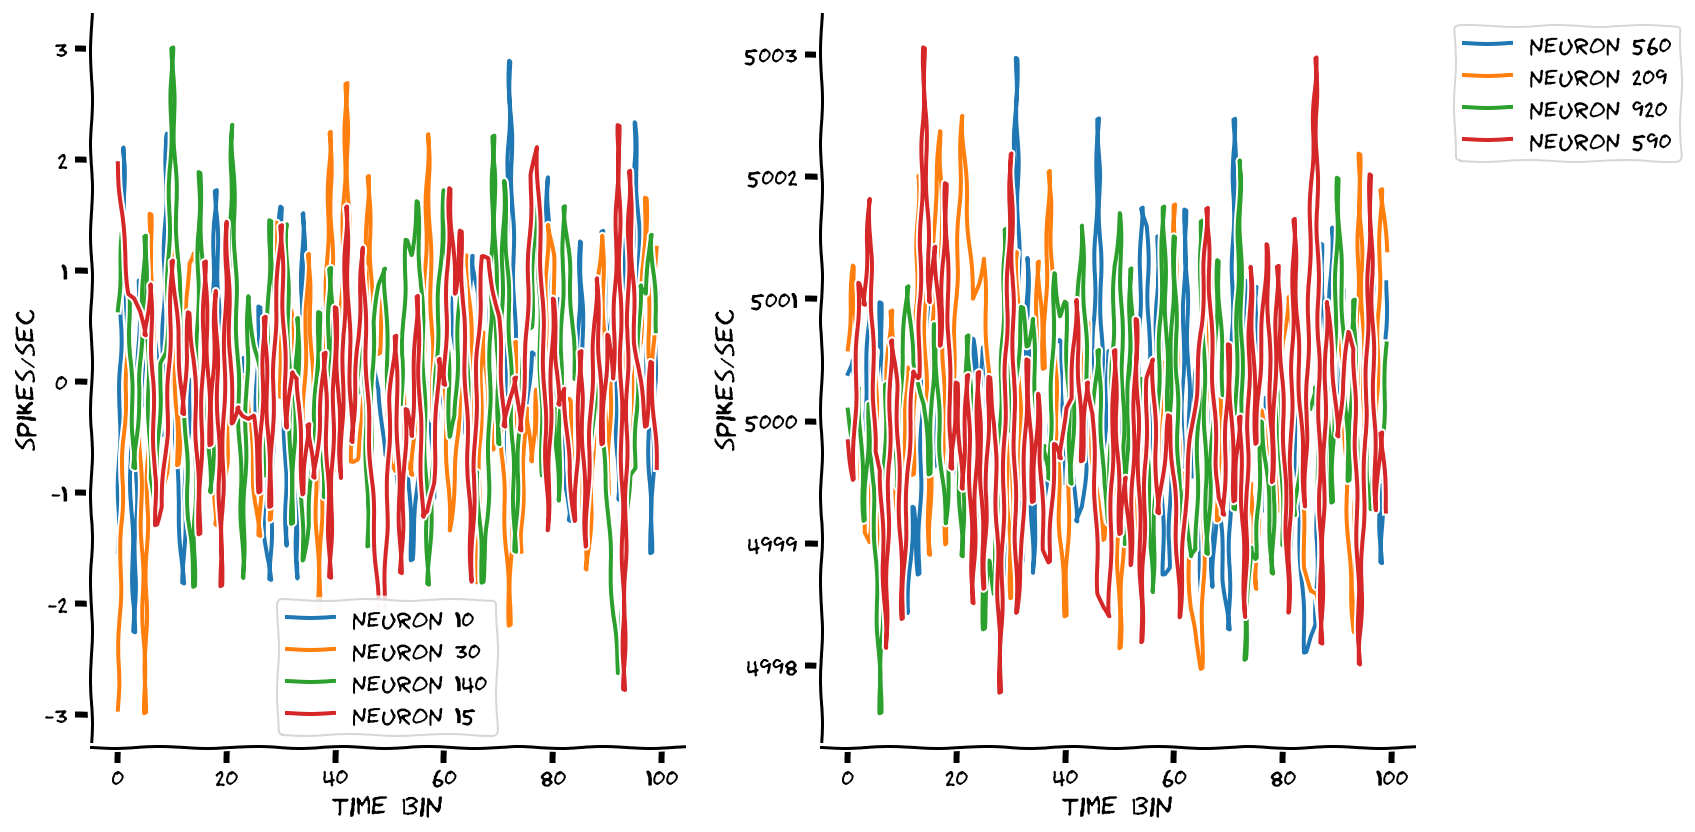

NameError: ignored

In [52]:
# Add an outliers in the training set
inputs_new = inputs.cpu().detach().numpy()

# Choose some neurons to be the outliers!
outliers = np.random.choice(range(len(inputs)), size=20, replace=False)
print("outliers:", outliers)
# Corrupt their firing! Incresa the spikes/s
for i in outliers:
    inputs_new[i, :] += 5000 * np.ones(inputs.shape[1])

# Plot some neurons to get an intuition of how the data look-like.
neuron_id = [10, 30, 140, 15]

with plt.xkcd():
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    for id in neuron_id:
        plt.plot(inputs_new[id, :], label=f"neuron {id}")
    plt.xlabel("time bin")
    plt.ylabel("spikes/sec")
    plt.legend()

    plt.subplot(1, 2, 2)
    for id in np.random.choice(outliers, size=4, replace=False):
        plt.plot(inputs_new[id, :], label=f"neuron {id}")
    plt.xlabel("time bin")
    plt.ylabel("spikes/sec")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

# Converting inputs and labels to Variable in pytorch
if torch.cuda.is_available():
    inputs_new = Variable(torch.from_numpy(x_train).float().cuda())
else:
    inputs_new = Variable(torch.from_numpy(x_train).float())


#### Exercise 6: Train two models; one with MSE and one with MAE loss functions


In [ ]:
def MSEvsMAE(inputs, targets):
    # input size dimension - features
    input_dim = inputs.shape[1]
    output_dim = targets.shape[1]
    # size of the hidden layer
    hidden = [50, 10]

    learningRate = 1e-5
    epochs = 2000

    # Create the model with MAE Loss
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    #raise NotImplementedError(
    #    "Construct the Network/Choose the L1 loss as loss function"
    #)
    ####################################################################
    modelMAE = SimpleNet(input_dim, hidden, output_dim) #.to(device)
    criterion_mae = nn.L1Loss()  # L1 Loss - Absolute error
    optimizerMAE = torch.optim.SGD(modelMAE.parameters(), lr=learningRate)

    # Create model with MSE loss
    modelMSE = SimpleNet(input_dim, hidden, output_dim).to(device)
    criterion_mse = nn.MSELoss()
    optimizerMSE = torch.optim.SGD(modelMSE.parameters(), lr=learningRate)

    # Training Loop for both models
    print("Training...")
    lossesMAE = []
    lossesMSE = []

    loss_testMAE = []
    loss_testMSE = []

    epoch_range = trange(epochs, desc="MAE: vs MSE:", leave=True)
    for epoch in epoch_range:
        if lossesMAE:
            epoch_range.set_description(
                "MAE: {:.4f} vs MSE: {:.4f}".format(lossesMAE[-1], lossesMSE[-1])
            )
            epoch_range.refresh()  # to show immediately the update
        time.sleep(0.01)

        # Clear gradient buffers because we don't want any gradient from
        # previous epoch to carry forward, dont want to cummulate gradients
        optimizerMAE.zero_grad()
        optimizerMSE.zero_grad()

        # get output from the model, given the inputs
        outputsMAE = modelMAE(inputs)
        outputsMSE = modelMSE(inputs)

        # get loss for the predicted output
        lossMAE = criterion_mae(outputsMAE, targets)
        lossMSE = criterion_mse(outputsMSE, targets)

        # get gradients w.r.t to parameters
        lossMAE.backward()
        lossMSE.backward()

        # update parameters
        optimizerMAE.step()
        optimizerMSE.step()
        lossesMAE.append(lossMAE.item())
        lossesMSE.append(lossMSE.item())

        loss_testMAE.append(criterion_mae(modelMAE(inputs_test), targets_test))
        loss_testMSE.append(criterion_mse(modelMSE(inputs_test), targets_test))

    return (
        modelMAE,
        modelMSE,
        criterion_mae,
        criterion_mse,
        lossesMAE,
        lossesMSE,
        loss_testMAE,
        loss_testMSE,
    )


## uncomment the lines below to test the training of the models
output = MSEvsMAE(inputs_new, targets)

MAE_test = output[2](output[0](inputs_test), targets_test)
loss_2 = output[3](output[1](inputs_test), targets_test)
RMSE_test = torch.sqrt(loss_2) # we take the square root of MSE to have both errors in the same scale
loss_comparison(output[4], output[5],
                output[6], output[7],
                RMSE_test, MAE_test)


### Section 6.2.3 Deciding which loss function to use

If the outliers represent anomalies that are important for our problem and thus should be detected, we should use **MSE**. On the other hand, if we believe that the outliers represent corrupted/wrong data, we should choose **MAE** as the loss function.

_L1 loss_ is more robust to outliers, but its derivatives are not continuous, making it inefficient to find the solution. _L2 loss_ is sensitive to outliers but gives a more stable and closed-form solution (by setting its derivative to 0.)

Overall, with outliers in the dataset, the MSE (L2 Loss) cost function tries to adjust the model according to these outliers at the expense of other good-samples since the squared-error is going to be huge for these outliers (for error > 1). On the other hand, MAE (L1 Loss) cost is quite resistant to outliers.
As a result, MSE cost may result in huge deviations in some of the samples, which results in reduced accuracy.

If we can ignore the outliers in our dataset or need them to be there, we should be using an MAE loss function. On the other hand, if you don’t want undesired outliers in the dataset and would like to use a stable solution, then, first of all, you should try to remove the outliers and then use an MSE loss function (unless the performance of a model with an L2 loss function may deteriorate badly due to the presence of outliers in the dataset).

**Problems with both:** There can be cases where neither MSE nor MAE loss functions give desirable predictions. For example, if $90%$ of observations in our data-set have a true target value of $1,000$ and the remaining $10%$ have target value between $0-100$. A model with MAE as loss might predict $1000$ for all observations, ignoring 10% of outlier cases, as it will try to go towards _median_ value. In the same case, a model using MSE would give many predictions in the range of $[0, 100]$ as it will get skewed towards outliers. Both results are undesirable in many real-world cases.


# Quiz


In [53]:
# @markdown What is the dimension of the hidden layer weight matrix in Section 1.2?
sequential = "In the exercise, we built a model with one input layer (1 x 10), the hidden layer (10 x 10) and one output layer (10 x 1)"  # @param {type:"string"}


In [54]:
# @markdown Go back to the crazy scaling plot in Section 4. Can you give a value at which the nonlinearity kicks-in?
xor = "using a scaling of around 2**120, the output of the hidden layer is nonlinear at least for some inputs"  # @param {type:"string"}


In [55]:
# @markdown Do you think the answer we found in Section 4 regarding XOR is correct, or is it a "hack"? Please give a short explanation for your opinion.
xor_solution = "I thinks it's a hack. It exploits the limitations of numerical representation in a computer."  # @param {type:"string"}


In [56]:
# @markdown What will happen in the learning dynamis if we increase/decrease the learning rate in Section 5, Exercise 5?
learning_modes = "if lr is too slow, the loss will never change or do so very slowly and thus singular values will remain almost same across epocs;  if we increase lr (but not too much to avoid nonconvergence), the model quickly reaches a minimum, and singular values quickly converge"  # @param {type:"string"}


In [57]:
# @markdown Can you think three applications where MSE and MAE, respectively, can be applied?
loss_func = "1) gene expression data and MSE, since some genes are barely expressed whereas others show strong expression values, but it's all important; 2) in the same situation in gene expression, you might be intersted in cases that are close to the median and avoid any extreme values, although potentially important for other scenarios; 3) MAE with phenotypic data where you know the range of possible values (like blood pressure), and any extreme is likely to be an outlier (corrupted data)"  # @param {type:"string"}


In [58]:
# @markdown In Section 6.2.2., do both the MSE and the MAE loss converge? Which one should we use?
loss_preference = "I couldn't complete this because there are errors in the notebook to download the data"  # @param {type:"string"}


---

# Wrap up: Linear Neural Networks


Video available at https://youtube.com/watch?v=uXIH35VZDis


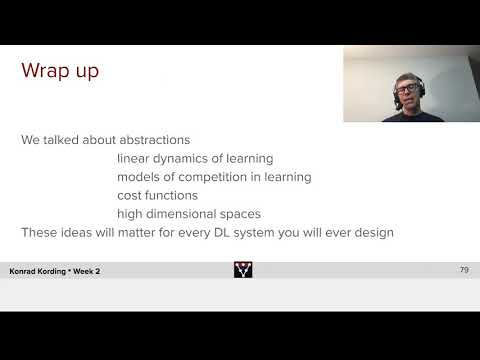

In [59]:
# @title Video: Wrap up
try:
    t7
except NameError:
    t7 = time.time()

video = YouTubeVideo(id="uXIH35VZDis", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


In [60]:
# @markdown #Run Cell to Show Airtable Form
# @markdown ##**Confirm your answers and then click "Submit"**

import time
import numpy as np
from IPython.display import IFrame


def prefill_form(src, fields: dict):
    """
    src: the original src url to embed the form
    fields: a dictionary of field:value pairs,
    e.g. {"pennkey": my_pennkey, "location": my_location}
    """
    prefills = "&".join(["prefill_%s=%s" % (key, fields[key]) for key in fields])
    src = src + prefills
    src = "+".join(src.split(" "))
    return src


# autofill time if it is not present
try:
    t0
except NameError:
    t0 = time.time()
try:
    t1
except NameError:
    t1 = time.time()

# autofill fields if they are not present
# a missing pennkey and pod will result in an Airtable warning
# which is easily fixed user-side.
try:
    my_pennkey
except NameError:
    my_pennkey = ""
try:
    my_pod
except NameError:
    my_pod = "Select"
try:
    sequential
except NameError:
    sequential = ""
try:
    xor
except NameError:
    xor = ""
try:
    xor_solution
except NameError:
    xor_solution = ""
try:
    learning_modes
except NameError:
    learning_modes = ""
try:
    loss_func
except NameError:
    loss_func = ""
try:
    loss_preference
except NameError:
    loss_func = ""

times = [(t - t0) for t in [t1]]

fields = {
    "pennkey": my_pennkey,
    "pod": my_pod,
    "email": my_email,
    "tutorial": tutorial,
    "sequential": sequential,
    "xor": xor,
    "xor_solution": xor_solution,
    "learning_modes": learning_modes,
    "loss_func": loss_func,
    "loss_preference": loss_preference,
    "cumulative_times": times,
}

src = "https://airtable.com/embed/shrdrQhQCMBuBw5s4?"
# now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src=prefill_form(src, fields), width=800, height=400))


---

# Feedback

How could this session have been better? How happy are you in your group? How do you feel right now? Run the following cell and tell us :)


In [61]:
# @markdown ##Run cell to show feedback form
# @markdown ####Confirm your answers and then click "Submit"

display(
    IFrame(
        src="https://airtable.com/embed/shr1TzujOOOY21kFQ?backgroundColor=red",
        width=800,
        height=400,
    )
)


---

# Optional Section


## Section 6.3 Cosine similarity: where cosine similarity is often a good idea


Video available at https://youtube.com/watch?v=n8HuO8OcU34


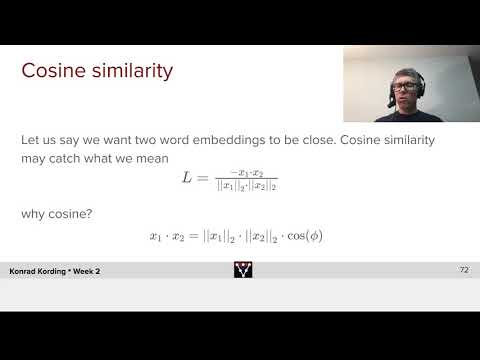

In [62]:
# @title Video: Cosine Similarity

video = YouTubeVideo(id="n8HuO8OcU34", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


On a lighter note, the embedding of a particular word (In Higher Dimension) is nothing but a vector representation of that word (In Lower Dimension). Where words with similar meaning Ex. “Joyful” and “Cheerful” and other closely related words like Ex. “Money” and “Bank”, gets closer vector representation when projected in the Lower Dimension.
The transformation from words to vectors is called `word embedding`.

Usually, in NLP application the loss function is the so-called Cosine Similarity. In mathematical terms, the cosine similarity between two vectors $x_1$ and $x_2$ is defined as:

\begin{equation}
CosineSimilarity = \frac{\left< x_1, x_2 \right>}{||x_1||\_2 \cdot ||x_2||\_2}
\end{equation}

where $||\cdot||_2$ denotes the _norm-2_ of a vector, i.e., the length of a vector, and $\left< \cdot, \cdot \right>$ denotes the dot product between the input vectors, i.e., $x_1^{\text{T}}x_2$.

The aforementioned equation is the definition of the Euclidean dot product between two vectors, i.e.,:

\begin{equation}
\left< x_1, x_2 \right> = ||x_1||\_2 \cdot ||x_2||\_2 \cdot \text{cos}(\phi)
\end{equation}

where $\phi$ is the angle between $x_1$ and $x_2$.

So the underlying concept in creating a mini word embedding boils down to train a simple linear neural network with only an input and an output layer!

Here, we will construct the training dataset with triplets of words, two of them belonging in the same sentence and the third one in a different sentence. One training example looks like this:

\begin{equation}
example = [word, same, different]
\end{equation}

We want to maximize the similarity of the words found in the same text while minimizing the similarity with the word from a different sentence.

The intuition is the following:

1. Cosine similarity (**cos_sim**) takes values in the range $[-1,1]$, but to minimize correlation, we want cosine to be $0$, and not $-1$.
2. We want to maximize the positive comparison ($cos\_sim(word,same)=1$) and minimize the negative comparison ($cos\_sim(word,diff)=0$)
3. The so-called _triplet margin loss_ is defined as $L = d(x_1,x_2) - d(x_1,x_3) + margin$, where $d(\cdot)$ denotes a distance metric, e.g., Euclidean distance, for some arbitrary vectors $x_1, x_2, x_3$.

Maximization of $cos\_sim(\cdot, \cdot)$ is equivalent of minimization of $1 - cos\_sim(\cdot, \cdot)$.

Taking all together, the triplet margin loss using cosine similarity mathematically is described as follows:

\begin{align}
L &{}= \left( 1-cos_sim(word,same) - (1-cos_sim(word,diff) \right) + margin \\
&{}= -cos_sim(word,same) + cos_sim(word,diff) + margin
\end{align}

The ideal loss would be $-1 + 0 + margin$.

Setting the $margin$ to $1$ would ensure that our loss could never be negative, but it is too aggressive. Thus, we usually pick a lower value, e.g., $0.5$.


In [63]:
# Sample Document (Recreated from the tom and jerry cartoon)

sample_docs = [
    "cat and mouse are buddies",
    "mouse lives in hole",
    "cat lives in house",
    "cat chases mouse",
    "cat catches mouse",
    "cat eats mouse",
    "mouse runs into hole",
    "cat says bad words",
    "cat and mouse are pals",
    "cat and mouse are chums",
    "mouse stores food in hole",
    "cat stores food in house",
    "mouse sleeps in hole",
    "cat sleeps in house",
]


### Section 6.3.1 Constructing the dataset

We aim to translate each word into a vector of real numbers. Towards this goal, first, we give an index to each word, and then we transform each word into a vector with all zeros but one position equal to one (one-hot encoding).

First, we assign an integer to each word in our vocabulary, consisting of all words in the text!


In [64]:
# Make and indexing from indices to words and vice versa
idx_2_word, word_2_idx = idx_word(sample_docs)

# Total vacabulary
vocab_size = len(idx_2_word)

# Transform the indices in one hot encoding
encoded_docs = [one_hot_map(d, word_2_idx) for d in sample_docs]

# Padding for consistency (i.e., adding zeros if the length is smaller than the max length)
max_length = max([len(e) for e in encoded_docs]) + 3
padded_docs = padding_seqs(encoded_docs, max_len=max_length)
print(padded_docs)


[[ 1  2  3  4  5  0  0  0]
 [ 3  6  7  8  0  0  0  0]
 [ 1  6  7  9  0  0  0  0]
 [ 1 10  3  0  0  0  0  0]
 [ 1 11  3  0  0  0  0  0]
 [ 1 12  3  0  0  0  0  0]
 [ 3 13 14  8  0  0  0  0]
 [ 1 15 16 17  0  0  0  0]
 [ 1  2  3  4 18  0  0  0]
 [ 1  2  3  4 19  0  0  0]
 [ 3 20 21  7  8  0  0  0]
 [ 1 20 21  7  9  0  0  0]
 [ 3 22  7  8  0  0  0  0]
 [ 1 22  7  9  0  0  0  0]]


Then, we map each integer into one-hot encoding. For example:

\begin{align}
`and` &{} \rightarrow `1` \rightarrow [0, 1, 0, 0, 0, 0, \dots, 0] \\
`buddies` &{} \rightarrow `4` \rightarrow [0, 0, 0, 0, 1, 0, \dots, 0]
\end{align}


In [65]:
# Construct the training data as triplets of [word1SameSentence, word2SameSentence, word3DiffSentence]
training_data = np.empty((0, 3))

for i in range(len(padded_docs)):
    sentence = padded_docs[i]
    x = sentence[np.argwhere(sentence != 0).squeeze()]
    x = np.unique(x)
    pairs = combinations(list(x))
    for comb in pairs:
        for j in range(len(padded_docs)):
            if j != i:
                sentence2 = padded_docs[j]
                y = sentence2[np.argwhere(sentence2 != 0).squeeze()]
                for xi in y:
                    training_data = np.append(
                        training_data, [[comb[0], comb[1], xi]], axis=0
                    )

# print the data shapes
print(training_data.shape)
# Shuffle the data
np.random.shuffle(training_data)
training_data = training_data

# Make the data one hot encoded
enc = OneHotEncoder()
enc.fit(np.array(range(vocab_size + 1)).reshape(-1, 1))
onehot_label_x1 = enc.transform(training_data[:, 0].reshape(-1, 1)).toarray()

enc = OneHotEncoder()
enc.fit(np.array(range(vocab_size + 1)).reshape(-1, 1))
onehot_label_x2 = enc.transform(training_data[:, 1].reshape(-1, 1)).toarray()

enc = OneHotEncoder()
enc.fit(np.array(range(vocab_size + 1)).reshape(-1, 1))
onehot_label_x3 = enc.transform(training_data[:, 2].reshape(-1, 1)).toarray()

# From Numpy to Torch
onehot_label_x1 = torch.from_numpy(onehot_label_x1)
onehot_label_x2 = torch.from_numpy(onehot_label_x2)
onehot_label_x3 = torch.from_numpy(onehot_label_x3)
print(onehot_label_x1.shape, onehot_label_x2.shape, onehot_label_x3.shape)


(5089, 3)
torch.Size([5089, 23]) torch.Size([5089, 23]) torch.Size([5089, 23])


### Section 6.3.2 Construct the model and train it


#### Exercise 7: Write the custom loss function

As we mentioned above, here we will use a modified triplet margin loss function. The input `x` in the function is a `3D` `torch.Tensor`, and it should return the average loss across `N` examples.

_Hint_: the input `x` has dimensions $(N \times L \times D)$, where $N$ denotes the number of the triplets, $L$ the number of words in the triplet (!!!), and $D$ the dimension of the embedding. You can use the `cosine_similarity` function from `torch.nn.functional` (see how we import it).


In [66]:
from torch.nn.functional import cosine_similarity

def criterion(x):
    margin = 0.5
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # raise NotImplementedError("Calculate the `mean` loss")
    ####################################################################
    loss = torch.mean(
        -cosine_similarity(x[:, 0], x[:, 1])
        + cosine_similarity(x[:, 0], x[:, 2])
        + margin
    )
    return loss


x = torch.tensor(
    [
        [[1.0, 2.0], [3.0, 2.0], [9.0, 2.0]],
        [[-1.0, 3.0], [4.0, 2.0], [8.0, 2.0]],
        [[1.0, 1.0], [-2.0, 1.0], [7.0, 4.0]],
    ]
)
print(x)

# uncomment the following line to check your function
print(criterion(x))


tensor([[[ 1.,  2.],
         [ 3.,  2.],
         [ 9.,  2.]],

        [[-1.,  3.],
         [ 4.,  2.],
         [ 8.,  2.]],

        [[ 1.,  1.],
         [-2.,  1.],
         [ 7.,  4.]]])
tensor(0.7751)


In [67]:
# to_remove solution
def criterion(x):
    margin = 0.5
    loss = torch.mean(
        -F.cosine_similarity(x[:, 0], x[:, 1])
        + F.cosine_similarity(x[:, 0], x[:, 2])
        + margin
    )

    return loss


x = torch.tensor(
    [
        [[1.0, 2.0], [3.0, 2.0], [9.0, 2.0]],
        [[-1.0, 3.0], [4.0, 2.0], [8.0, 2.0]],
        [[1.0, 1.0], [-2.0, 1.0], [7.0, 4.0]],
    ]
)
print(x)

print(criterion(x))


tensor([[[ 1.,  2.],
         [ 3.,  2.],
         [ 9.,  2.]],

        [[-1.,  3.],
         [ 4.,  2.],
         [ 8.,  2.]],

        [[ 1.,  1.],
         [-2.,  1.],
         [ 7.,  4.]]])
tensor(0.7751)


loss:   0%|          | 0/100 [00:00<?, ?it/s]

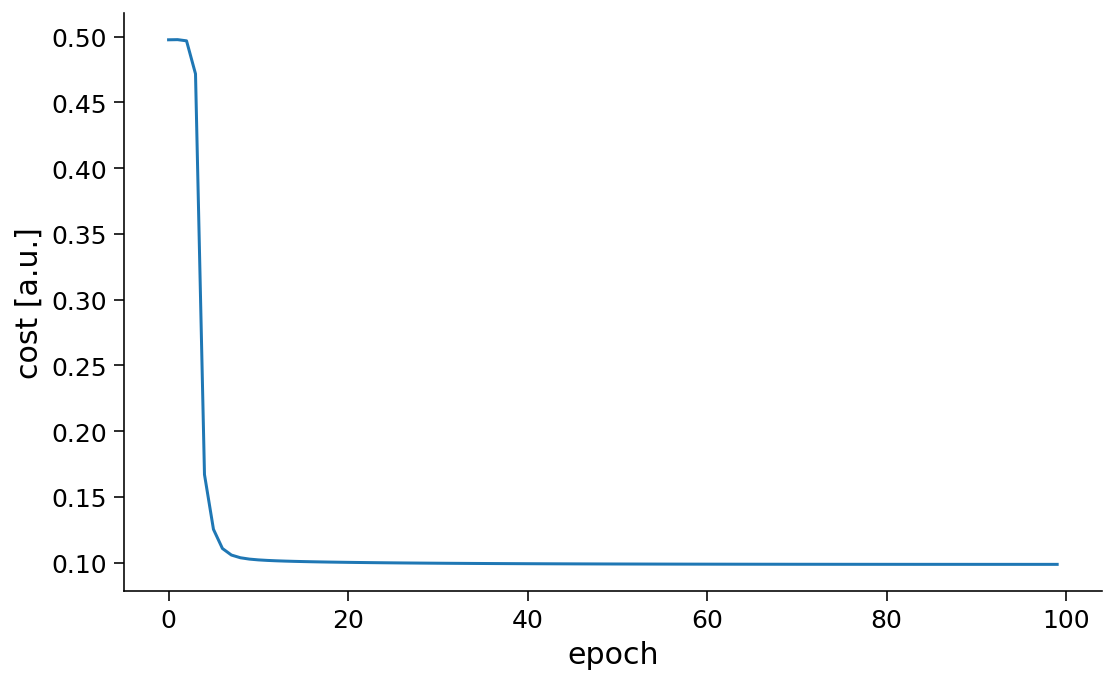

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = vocab_size + 1
hidden_size = 2
learning_rate = 0.01
num_epochs = 100
batch_size = 10

# Our simple model
net = nn.Linear(input_size, hidden_size)

# Weights initialization
sigma = 0.01
net.weight.data.normal_(0, sigma)
net.bias.data.normal_(0, sigma)

net.to(device)
net.train(True)

# Optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

# Training loop
loss_val = []
_data = (
    torch.stack((onehot_label_x1, onehot_label_x2, onehot_label_x3), axis=1)
    .float()
    .to(device)
)


epoch_range = trange(num_epochs, desc="loss: ", leave=True)
for epoch in epoch_range:
    if loss_val:
        epoch_range.set_description("loss: {:.6f}".format(loss_val[-1]))
        epoch_range.refresh()  # to show immediately the update
    time.sleep(0.01)

    for idx in range(0, len(_data), batch_size):
        batch = _data[idx : idx + batch_size]

        # Forward pass
        output = net(batch.float())

        # Custom loss
        loss = criterion(output)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_val.append(loss.item())

plt.figure(figsize=(8, 5))
plt.plot(loss_val)
plt.ylabel("cost [a.u.]")
plt.xlabel("epoch")
plt.show()


### Section 6.3.2: Evaluate model's performance


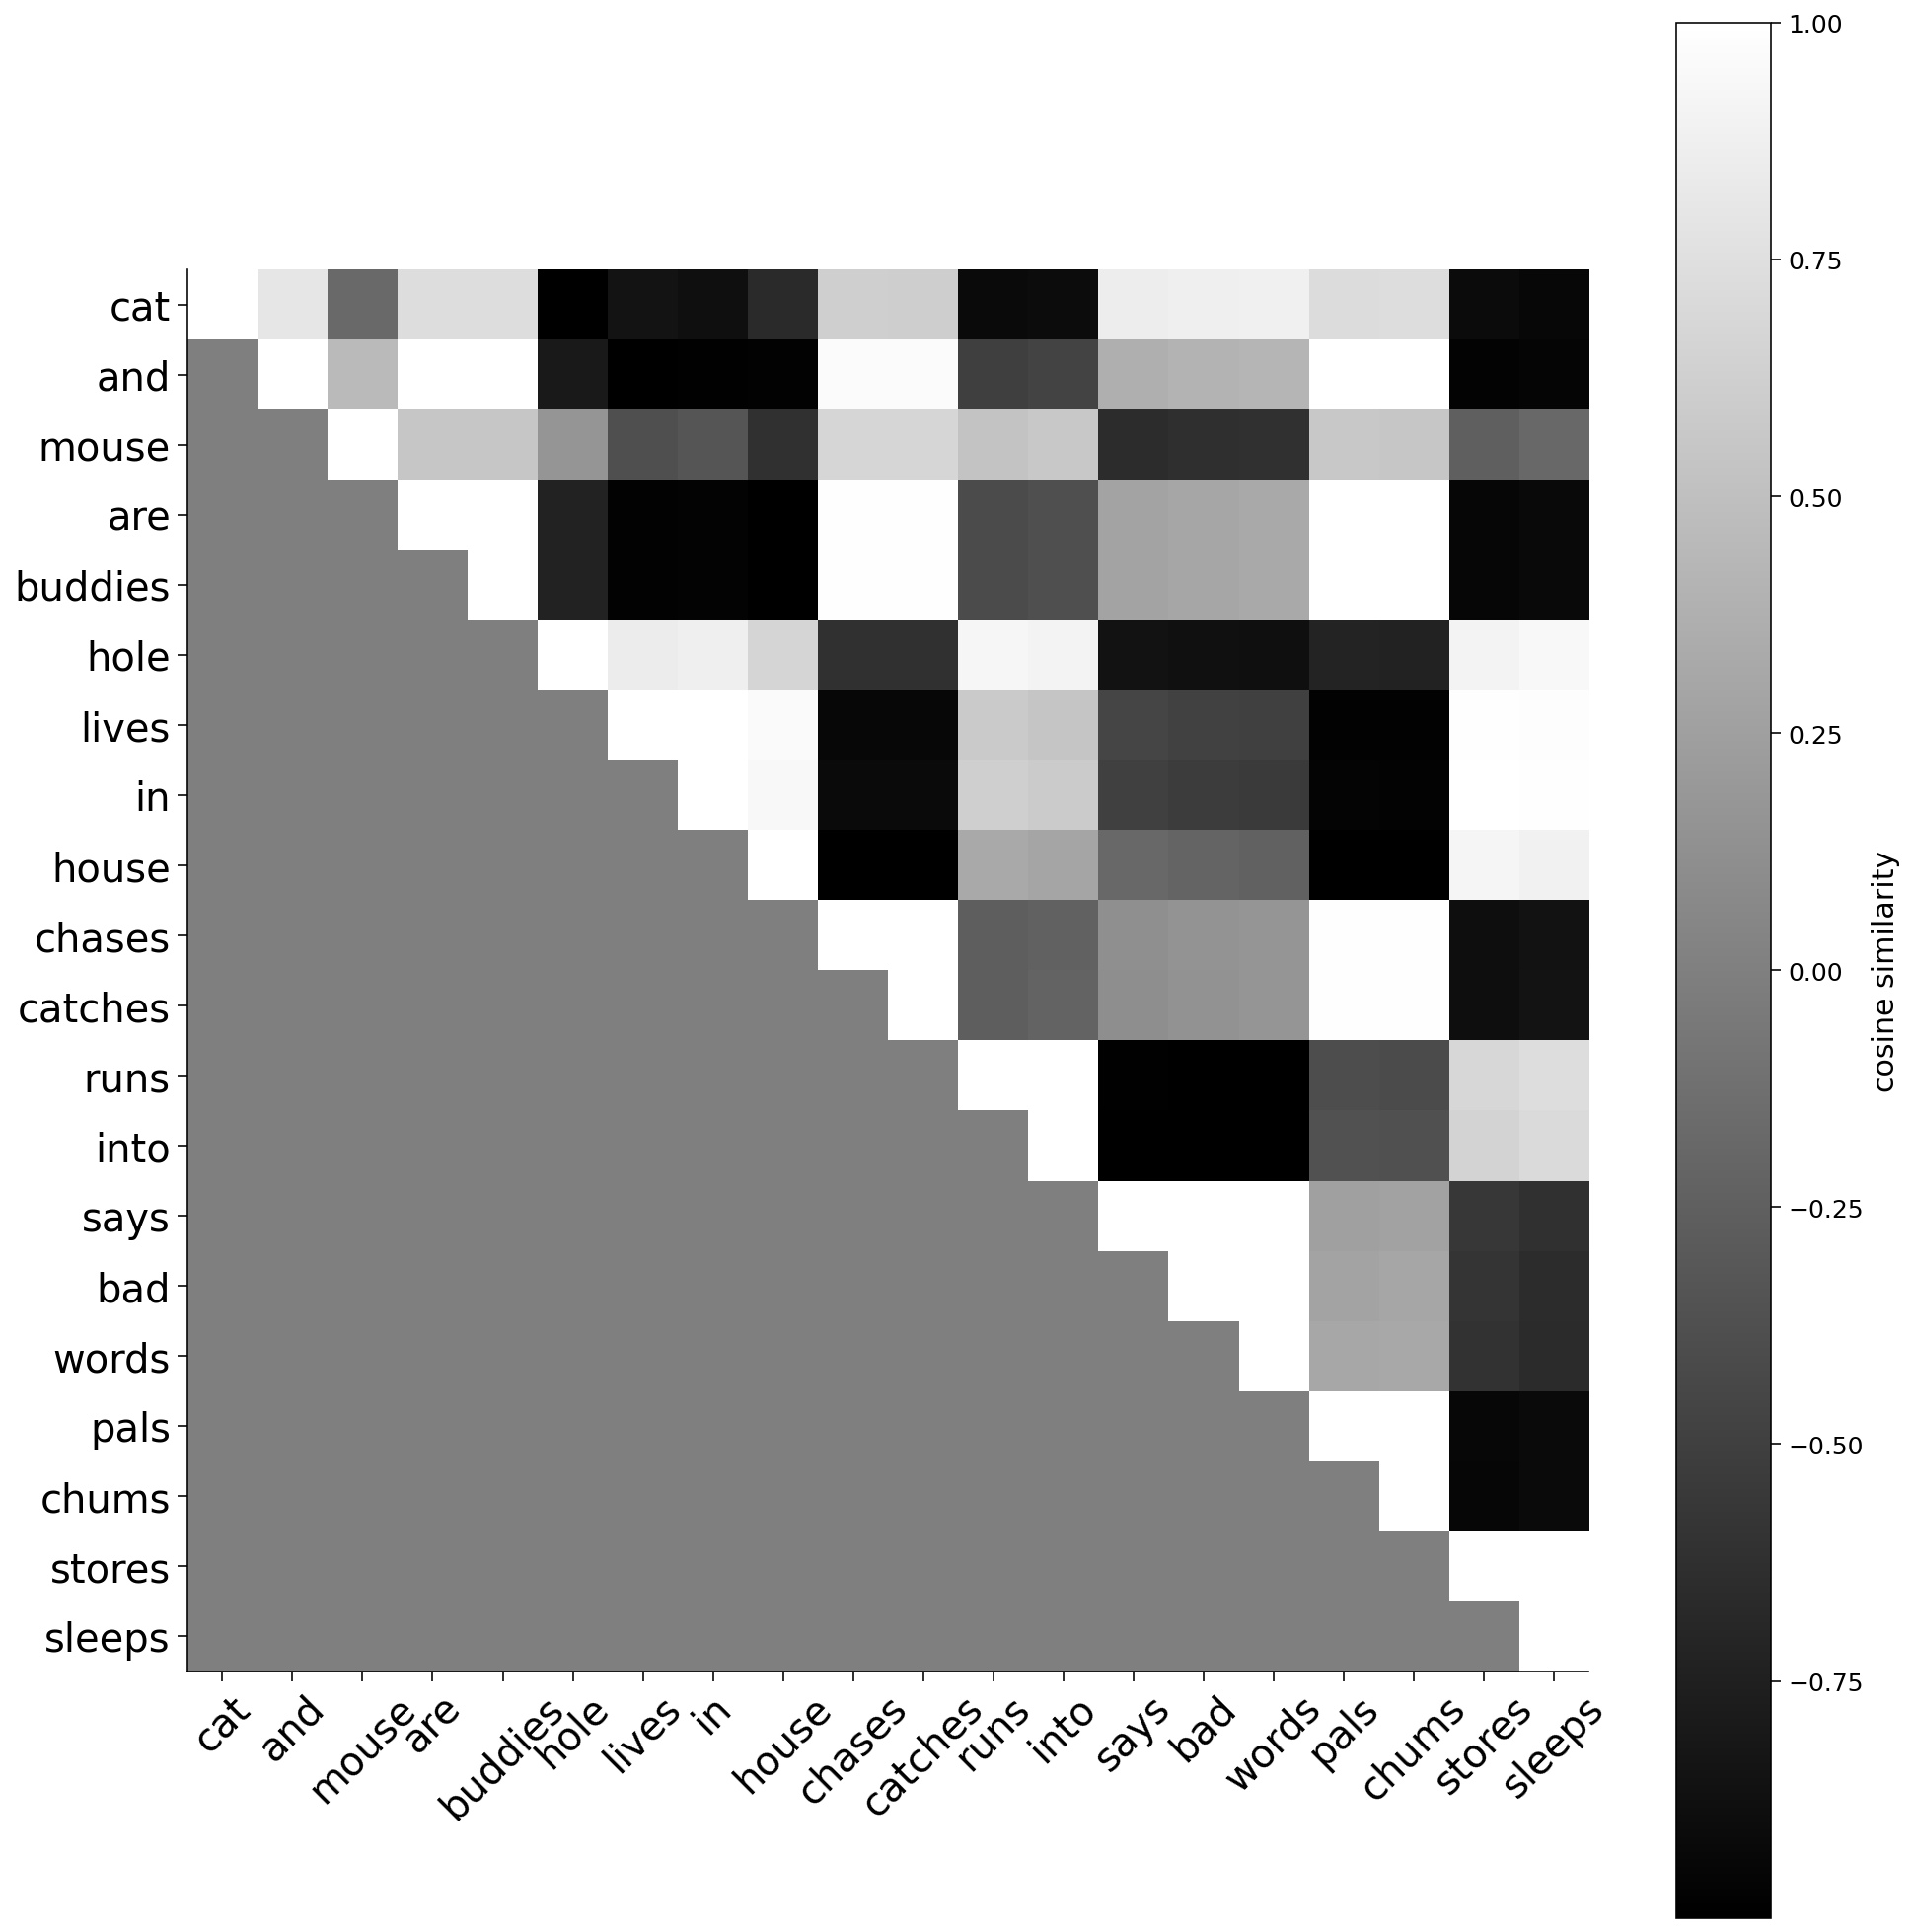

In [69]:
docs = [
    "cat and mouse are buddies hole lives in house chases catches runs "
    "into says bad words pals chums stores sleeps"
]
encoded_docs = [one_hot_map(d, word_2_idx) for d in docs]

test_arr = np.array(
    [
        [
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            8.0,
            6.0,
            7.0,
            9.0,
            10.0,
            11.0,
            13.0,
            14.0,
            15.0,
            16.0,
            17.0,
            18.0,
            19.0,
            20.0,
            22.0,
        ]
    ]
)
test = enc.transform(test_arr.reshape(-1, 1)).toarray().astype(np.float32)
test = torch.from_numpy(test).float().to(device)

docs = [
    "cat",
    "and",
    "mouse",
    "are",
    "buddies",
    "hole",
    "lives",
    "in",
    "house",
    "chases",
    "catches",
    "runs",
    "into",
    "says",
    "bad",
    "words",
    "pals",
    "chums",
    "stores",
    "sleeps",
]

with torch.no_grad():
    output = net(test)

# Cosine Similarity Matrix
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

similarities = np.empty((len(output), len(output)))

for i in range(len(output)):
    for j in range(len(output)):
        similarities[i, j] = cos(output[i], output[j])

plt.figure(figsize=(14, 14))
plt.imshow(np.triu(similarities), cmap="gray")
cbar = plt.colorbar()
cbar.ax.set_ylabel("cosine similarity")
plt.xticks(range(len(docs)), docs, rotation=45, fontsize=20)
plt.yticks(range(len(docs)), docs, fontsize=20)
plt.show()


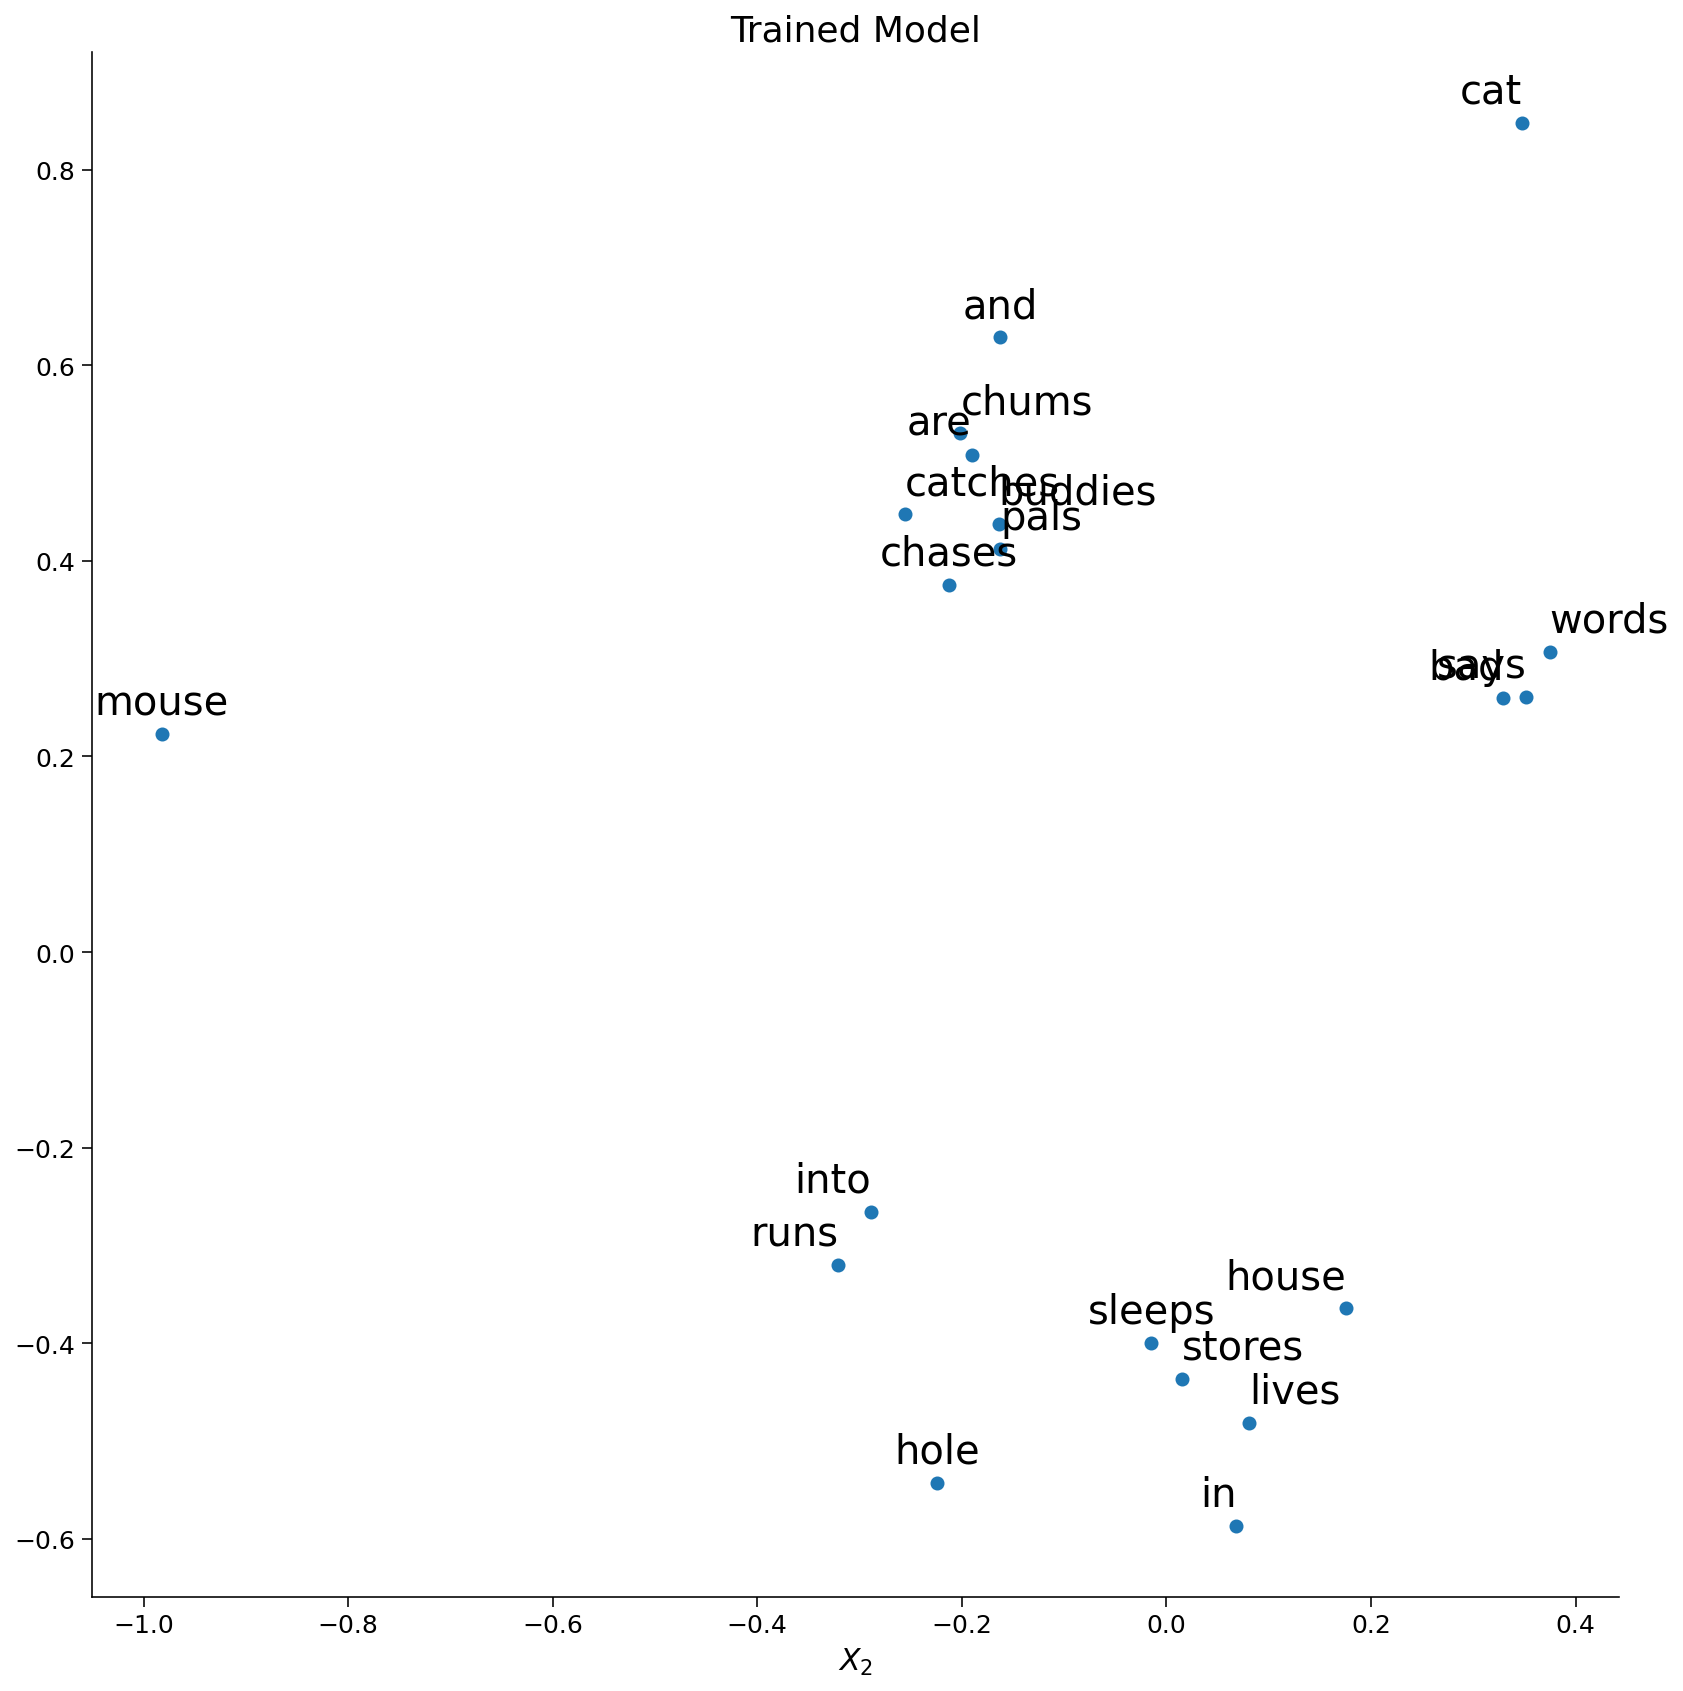

In [70]:
xs = []
ys = []
for i in range(len(output)):
    xs.append(output[i][0].cpu().detach().numpy())
    ys.append(output[i][1].cpu().detach().numpy())

docs = [
    "cat",
    "and",
    "mouse",
    "are",
    "buddies",
    "hole",
    "lives",
    "in",
    "house",
    "chases",
    "catches",
    "runs",
    "into",
    "says",
    "bad",
    "words",
    "pals",
    "chums",
    "stores",
    "sleeps",
]

plt.figure(figsize=(12, 12))
plt.scatter(xs, ys)
label = docs

for i, (x, y) in enumerate(zip(xs, ys)):
    plt.annotate(
        label[i],
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        fontsize=20,
        ha=random.choice(["left", "right", "center"]),
    )
    plt.title("Trained Model")
    plt.xlabel("$X_1$")
    plt.xlabel("$X_2$")
plt.show()


In the plot above, we can see how the word embeddings we learn are distributed in the $2D$ space. Notice that `mouse` and `cat` are separated in space. The words `buddies`, `pals`, and `chums` are close to one another. This linear embedding 'semantically' makes sense, right?

Obviously, as you will learn later in the course, more sophisticated NLP approaches can build a word embedding. Here, we explore one of the simplest cases, showing an interesting way of using the cosine similarity.


---

## Section 7: High dimensional spaces intuition


Video available at https://youtube.com/watch?v=OyiHIFqJvJ0


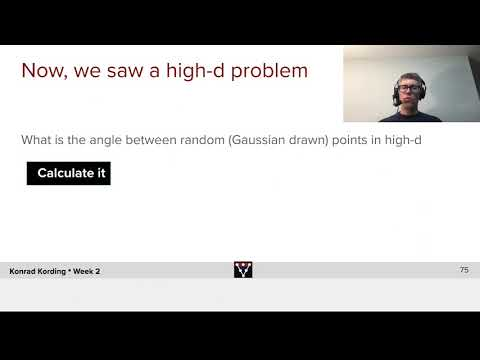

In [71]:
# @title Video: Angle between Gaussian Drawn High Dimensional Vectors

video = YouTubeVideo(id="OyiHIFqJvJ0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


Calculate the angles between two vectors sampled from an isotropic gaussian, i.e., $x_i, y_i \sim \mathcal{N}(0, \sigma^2I_D)$.


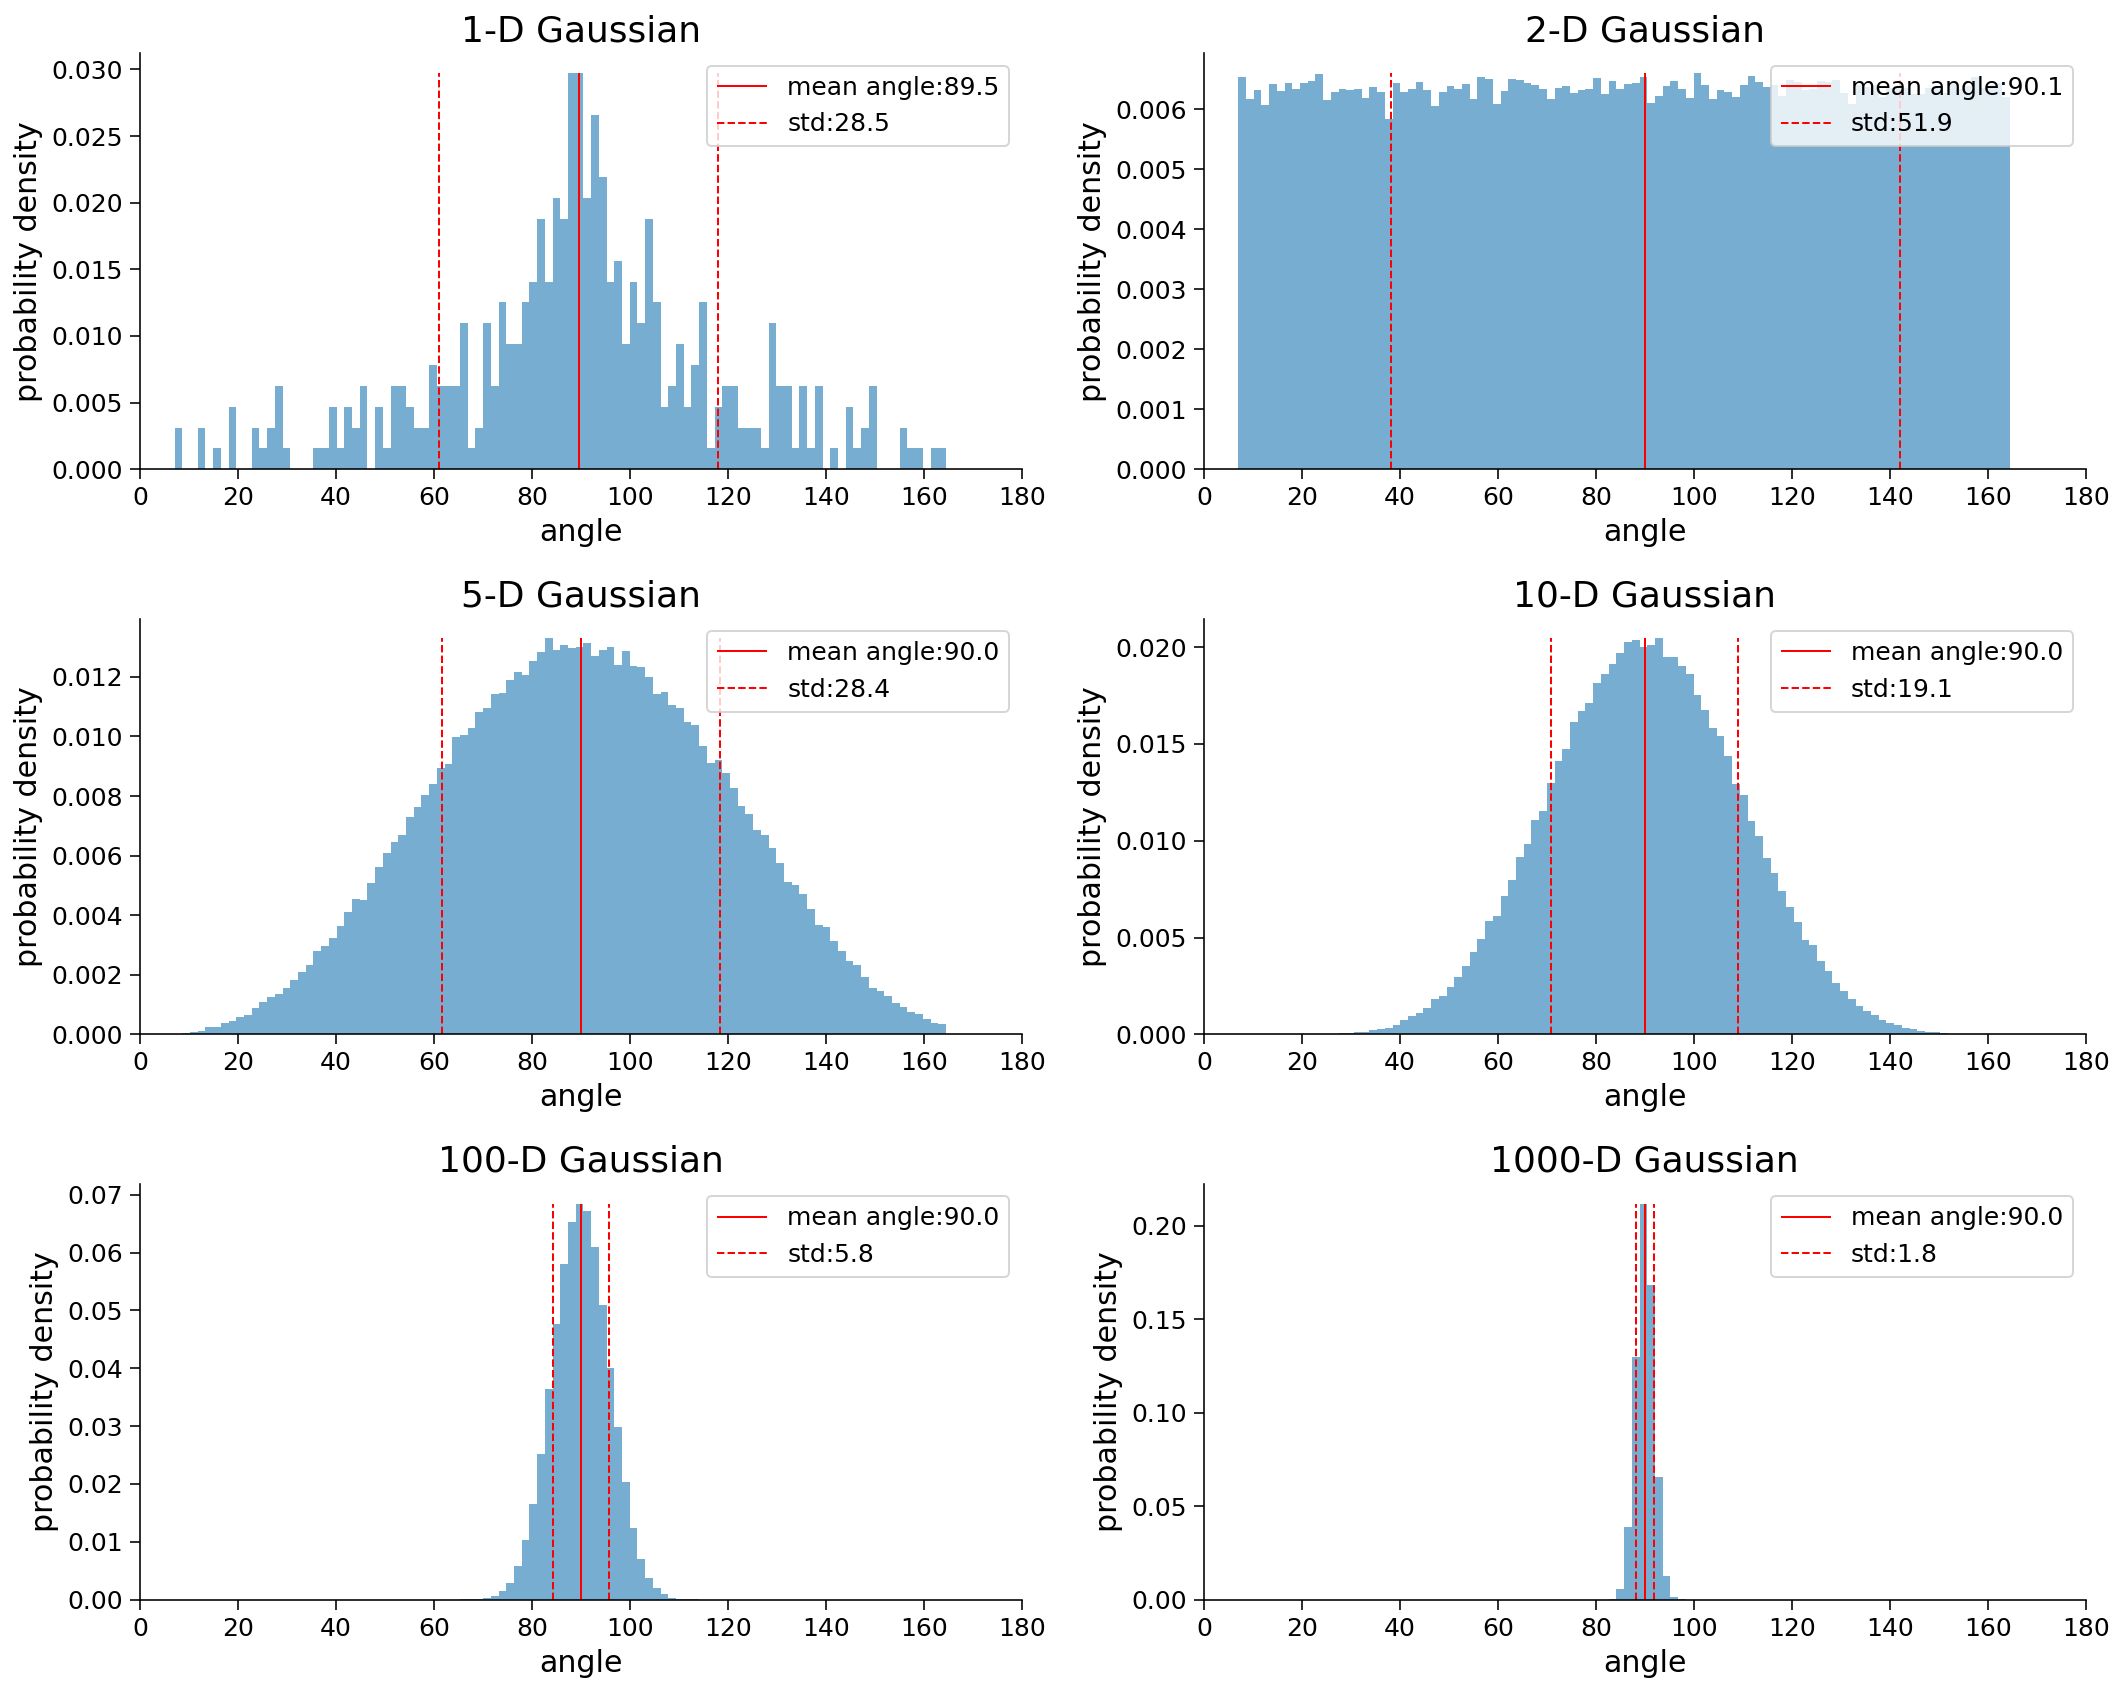

In [72]:
def plot_angles(sample_size, dimensions):

    plt.figure(figsize=(15, 12))
    for cnt, D in enumerate(dimensions):

        angles = []

        if D != 1:
            mean = np.zeros(D)
            cov = 2 * np.eye(D)  # diagonal covariance, i.e., isotropic gaussian
            x = np.random.multivariate_normal(mean, cov, size=sample_size).T
            x /= np.linalg.norm(x, axis=0).reshape(1, -1)
            y = np.random.multivariate_normal(mean, cov, size=sample_size).T
            y /= np.linalg.norm(y, axis=0).reshape(1, -1)
            dot_product = np.dot(x.T, y)
            angles = np.arccos(dot_product)
            angles = angles[~np.isnan(angles)]

        elif D == 1:
            x = np.random.randn(sample_size)
            y = np.random.randn(sample_size)
            dot_product = x * y
            angles = np.arccos(dot_product)
            angles = angles[~np.isnan(angles)]

        if cnt == 0:
            bins = np.histogram(np.degrees(angles), bins=100)[1]  # get the bin edges

        mean = np.round(np.mean(np.degrees(angles)), 1)
        std = np.round(np.std(np.degrees(angles)), 1)
        plt.subplot(3, 2, cnt + 1)
        vals, bins, p = plt.hist(np.degrees(angles), bins=bins, density=True, alpha=0.6)
        plt.xlabel("angle")
        plt.xlim([0, 180])
        plt.vlines(
            x=mean,
            ymin=0.0,
            ymax=max(vals),
            colors="red",
            linewidth=1.0,
            label=f"mean angle:{mean}",
        )
        plt.vlines(
            x=mean - std,
            ymin=0.0,
            ymax=max(vals),
            colors="red",
            linewidth=1.0,
            linestyle="--",
            label=f"std:{std}",
        )
        plt.vlines(
            x=mean + std,
            ymin=0.0,
            ymax=max(vals),
            colors="red",
            linewidth=1.0,
            linestyle="--",
        )
        plt.ylabel("probability density")
        plt.title(f"{D}-D Gaussian")
        plt.legend()

    plt.tight_layout()


sample_size = 500
dimensions = [1, 2, 5, 10, 100, 1000]
plot_angles(sample_size, dimensions)


Notice that, as we increase the Gaussian dimensions, the mean angle is $90$ degrees and is constant, but the standard deviation becomes smaller and smaller. Thus, as $D \rightarrow \infty$, the angle between two randomly sampled vectors becomes $90$ degrees, i.e., the two vectors are orthogonal.


Video available at https://youtube.com/watch?v=1p2nip3qnO0


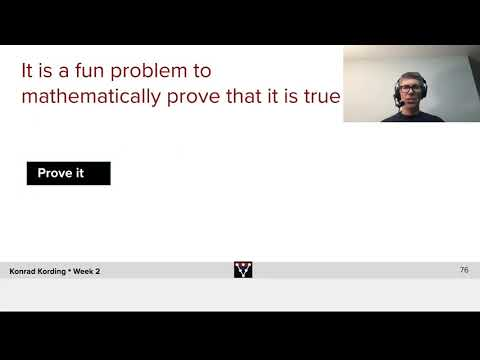

In [73]:
# @title Video:Prove 90 Degrees

video = YouTubeVideo(id="1p2nip3qnO0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


### Proof of 90 degrees in high $D$ space

Here, we want to prove that the angle between two vectors becomes zero as we increase the dimensions of vectors sampled from an isotropic normal distribution.

\begin{equation}
\textbf{x, y} \sim \mathcal{N}(0, \sigma I_D)
\end{equation}

where $I_D$ is the $D\times D$ identity matrix.

We want to find the expectation and the variance of the angle ($\theta$) between $\textbf{x}$ and $\text{y}$, so we need to calculate the $cos(\theta)$

We know that

\begin{equation}
\textbf{x}^{\text{T}} \textbf{y} = ||\textbf{x}||\_2||\textbf{y}||\_2 cos(\theta) \iff \\
cos(\theta) = \frac{\textbf{x}^{\text{T}} \textbf{y}}{||\textbf{x}||\_2 \cdot ||\textbf{y}||\_2}
\end{equation}

where $||\cdot||_2$ denotes the norm-2, or mathematically $||\textbf{x}||_2 = \sqrt{ \sum_{i=1}^Dx_i^2}$.

So, we want to find the expectation and the variance of all terms involved.

\begin{equation}
\mathbb{E}\left[ \textbf{x}^{\text{T}} \textbf{y} \right] = 0
\end{equation}

because both $\textbf{x}$ and $\textbf{y}$ are zero-mean and are uncorrelated.

Also, we know that

\begin{equation}
\mathbb{E}\left[ || \textbf{x} ||_2 \right] = \sqrt{2} \sigma \frac{ \Gamma\left( \frac{D+1}{2} \right) } {\Gamma \left( \frac{D}{2}\right)}
\end{equation}

where $\Gamma( \cdot )$ is the [**Gamma function**](https://en.wikipedia.org/wiki/Gamma_function), $\Gamma(n) = (n-1)!$, $\Gamma \left( n + \frac{1}{2} \right) = {n - \frac{1}{2}\choose n} n! \sqrt{\pi}$

Thus, the expectation of the angle goes to zero, and the corresponding angles are $90^o$. So, what we care about here is the variance.

By definition, we know that:

\begin{equation}
Var(||\textbf{x}||\_2) = \mathbb{E}\left[ ||\textbf{x}||_2^2\right] - \left( \mathbb{E}\left[ ||\textbf{x}||_2\right] \right)^2
\end{equation}

The expectation of the squared norm can be written as:

\begin{equation}
\mathbb{E}(||\textbf{x}||_2^2) = \mathbb{E}\left[ \sum_{i=1}^{D}x*i^2\right] = \sum*{i=1}^{D}\mathbb{E}\left[ x_i^2 \right] = \sum\_{i=1}^{D}Var(x_i) = trace(\Sigma) = D\sigma^2
\end{equation}

as $\textbf{x}$ is zero-mean distributed.

Thus,

\begin{equation}
Var(||\textbf{x}||\_2) = D\sigma^2 - 2\sigma^2 \left( \frac{ \Gamma\left( \frac{D+1}{2} \right) } {\Gamma \left( \frac{D}{2}\right)} \right)^2
\end{equation}

In very high dimensional spaces, $\frac{D+1}{2} \approx \frac{D}{2}$ and so the formula is reduced in:

\begin{equation}
Var(||\textbf{x}||\_2) = \sigma^2 (D - 2) \approx D\sigma^2
\end{equation}

Next, we calculate the variance of the inner product:

\begin{equation}
Var(\textbf{x}^{\text{T}} \textbf{y}) = Var\left(\sum*{i=1}^{D} x_iy_i \right) = \sum*{i=1}^{D}Var(x_iy_i) = D\sigma^2
\end{equation}

Thus, the variance of the angles approaches zero as we increase dimensions because the variance in the denominator is much higher than this in the numerator.

So, at high dimensional spaces, two random vectors are orthogonal in average.


### Distance of high dimensional vectors


Video available at https://youtube.com/watch?v=HXPZWoobWXs


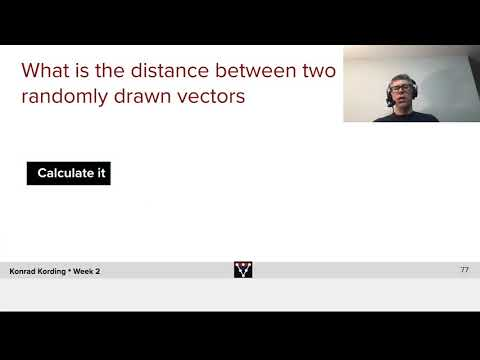

In [74]:
# @title Video: Distance Between Gaussian Drawn High Dimensional Vectors

video = YouTubeVideo(id="HXPZWoobWXs", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video


We have calculated the angle between two randomly sampled vectors, we calculate their distance, i.e., the norm of their difference. Note that, in $1D$ case, we plot the absolute difference of the two vectors.


#### Exercise 8: Plot distances in high D spaces

Now is your turn to calculate the distances in variable dimensional spaces. You may found the command `np.linalg.norm` useful. Execute `? np.linalg.norm` in a scratch cell to see its DocString.

_Hint:_ Choose the axis of the input `ndarray` of `np.linalg.norm` along which to compute the vector norms wisely...


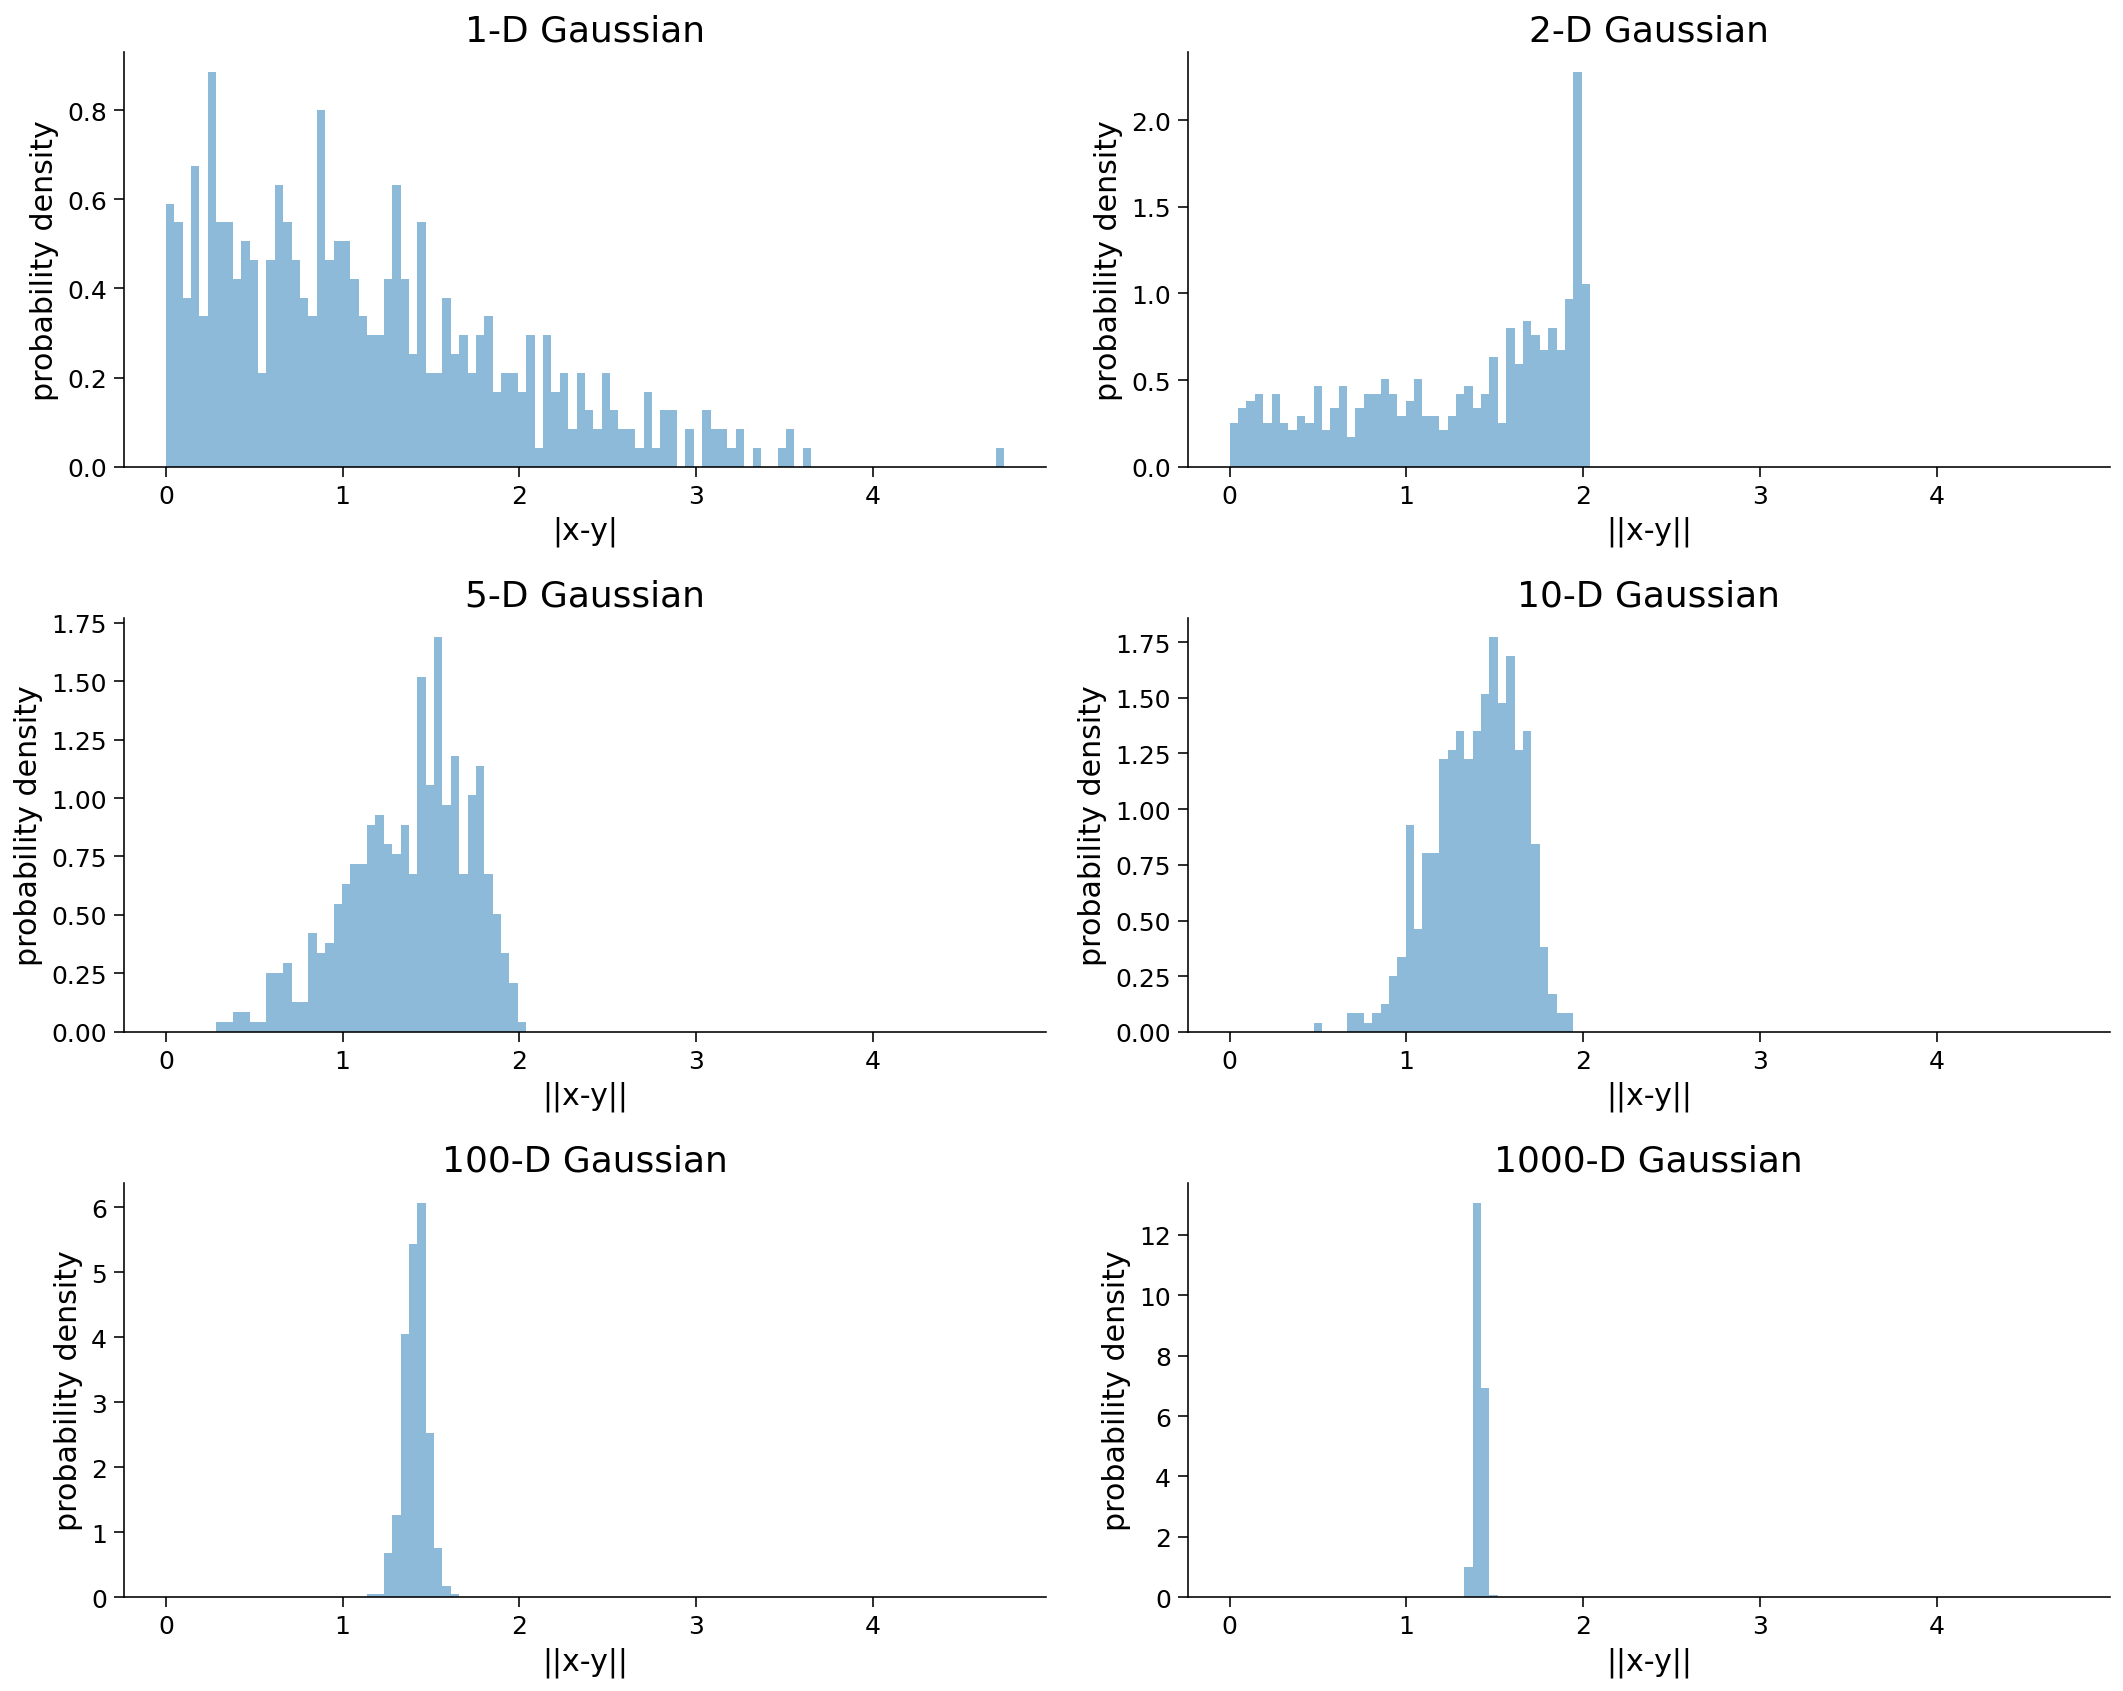

In [75]:
def plot_distances(sample_size, dimensions):

    plt.figure(figsize=(15, 12))
    for cnt, D in enumerate(dimensions):

        norms = []

        if D != 1:
            mean = np.zeros(D)
            cov = 2 * np.eye(D)  # diagonal covariance, i.e., isotropic gaussian
            x = np.random.multivariate_normal(mean, cov, size=sample_size).T
            x /= np.linalg.norm(x, axis=0).reshape(1, -1)
            y = np.random.multivariate_normal(mean, cov, size=sample_size).T
            y /= np.linalg.norm(y, axis=0).reshape(1, -1)
            ####################################################################
            # Fill in missing code below (...),
            # then remove or comment the line below to test your function
            #raise NotImplementedError("Calculate the distance in D>2 spaces")
            ####################################################################
            norms = np.linalg.norm(x - y, axis=0)

        elif D == 1:
            x = np.random.randn(sample_size)
            y = np.random.randn(sample_size)
            ####################################################################
            # Fill in missing code below (...),
            # then remove or comment the line below to test your function
            # raise NotImplementedError("Calculate the distance in 1D space")
            ####################################################################
            # print(x.shape)
            norms = np.abs(x - y)

        if cnt == 0:
            bins = np.histogram(norms, bins=100)[1]  # get the bin edges
        plt.subplot(3, 2, cnt + 1)
        plt.hist(norms, bins=bins, density=True, alpha=0.5)
        if D == 1:
            plt.xlabel("|x-y|")
        else:
            plt.xlabel("||x-y||")

        plt.ylabel("probability density")
        plt.title(f"{D}-D Gaussian")

    plt.tight_layout()


## uncomment the line below to test your functionx, y
sample_size = 500
dimensions = [1, 2, 5, 10, 100, 1000]
plot_distances(sample_size, dimensions)


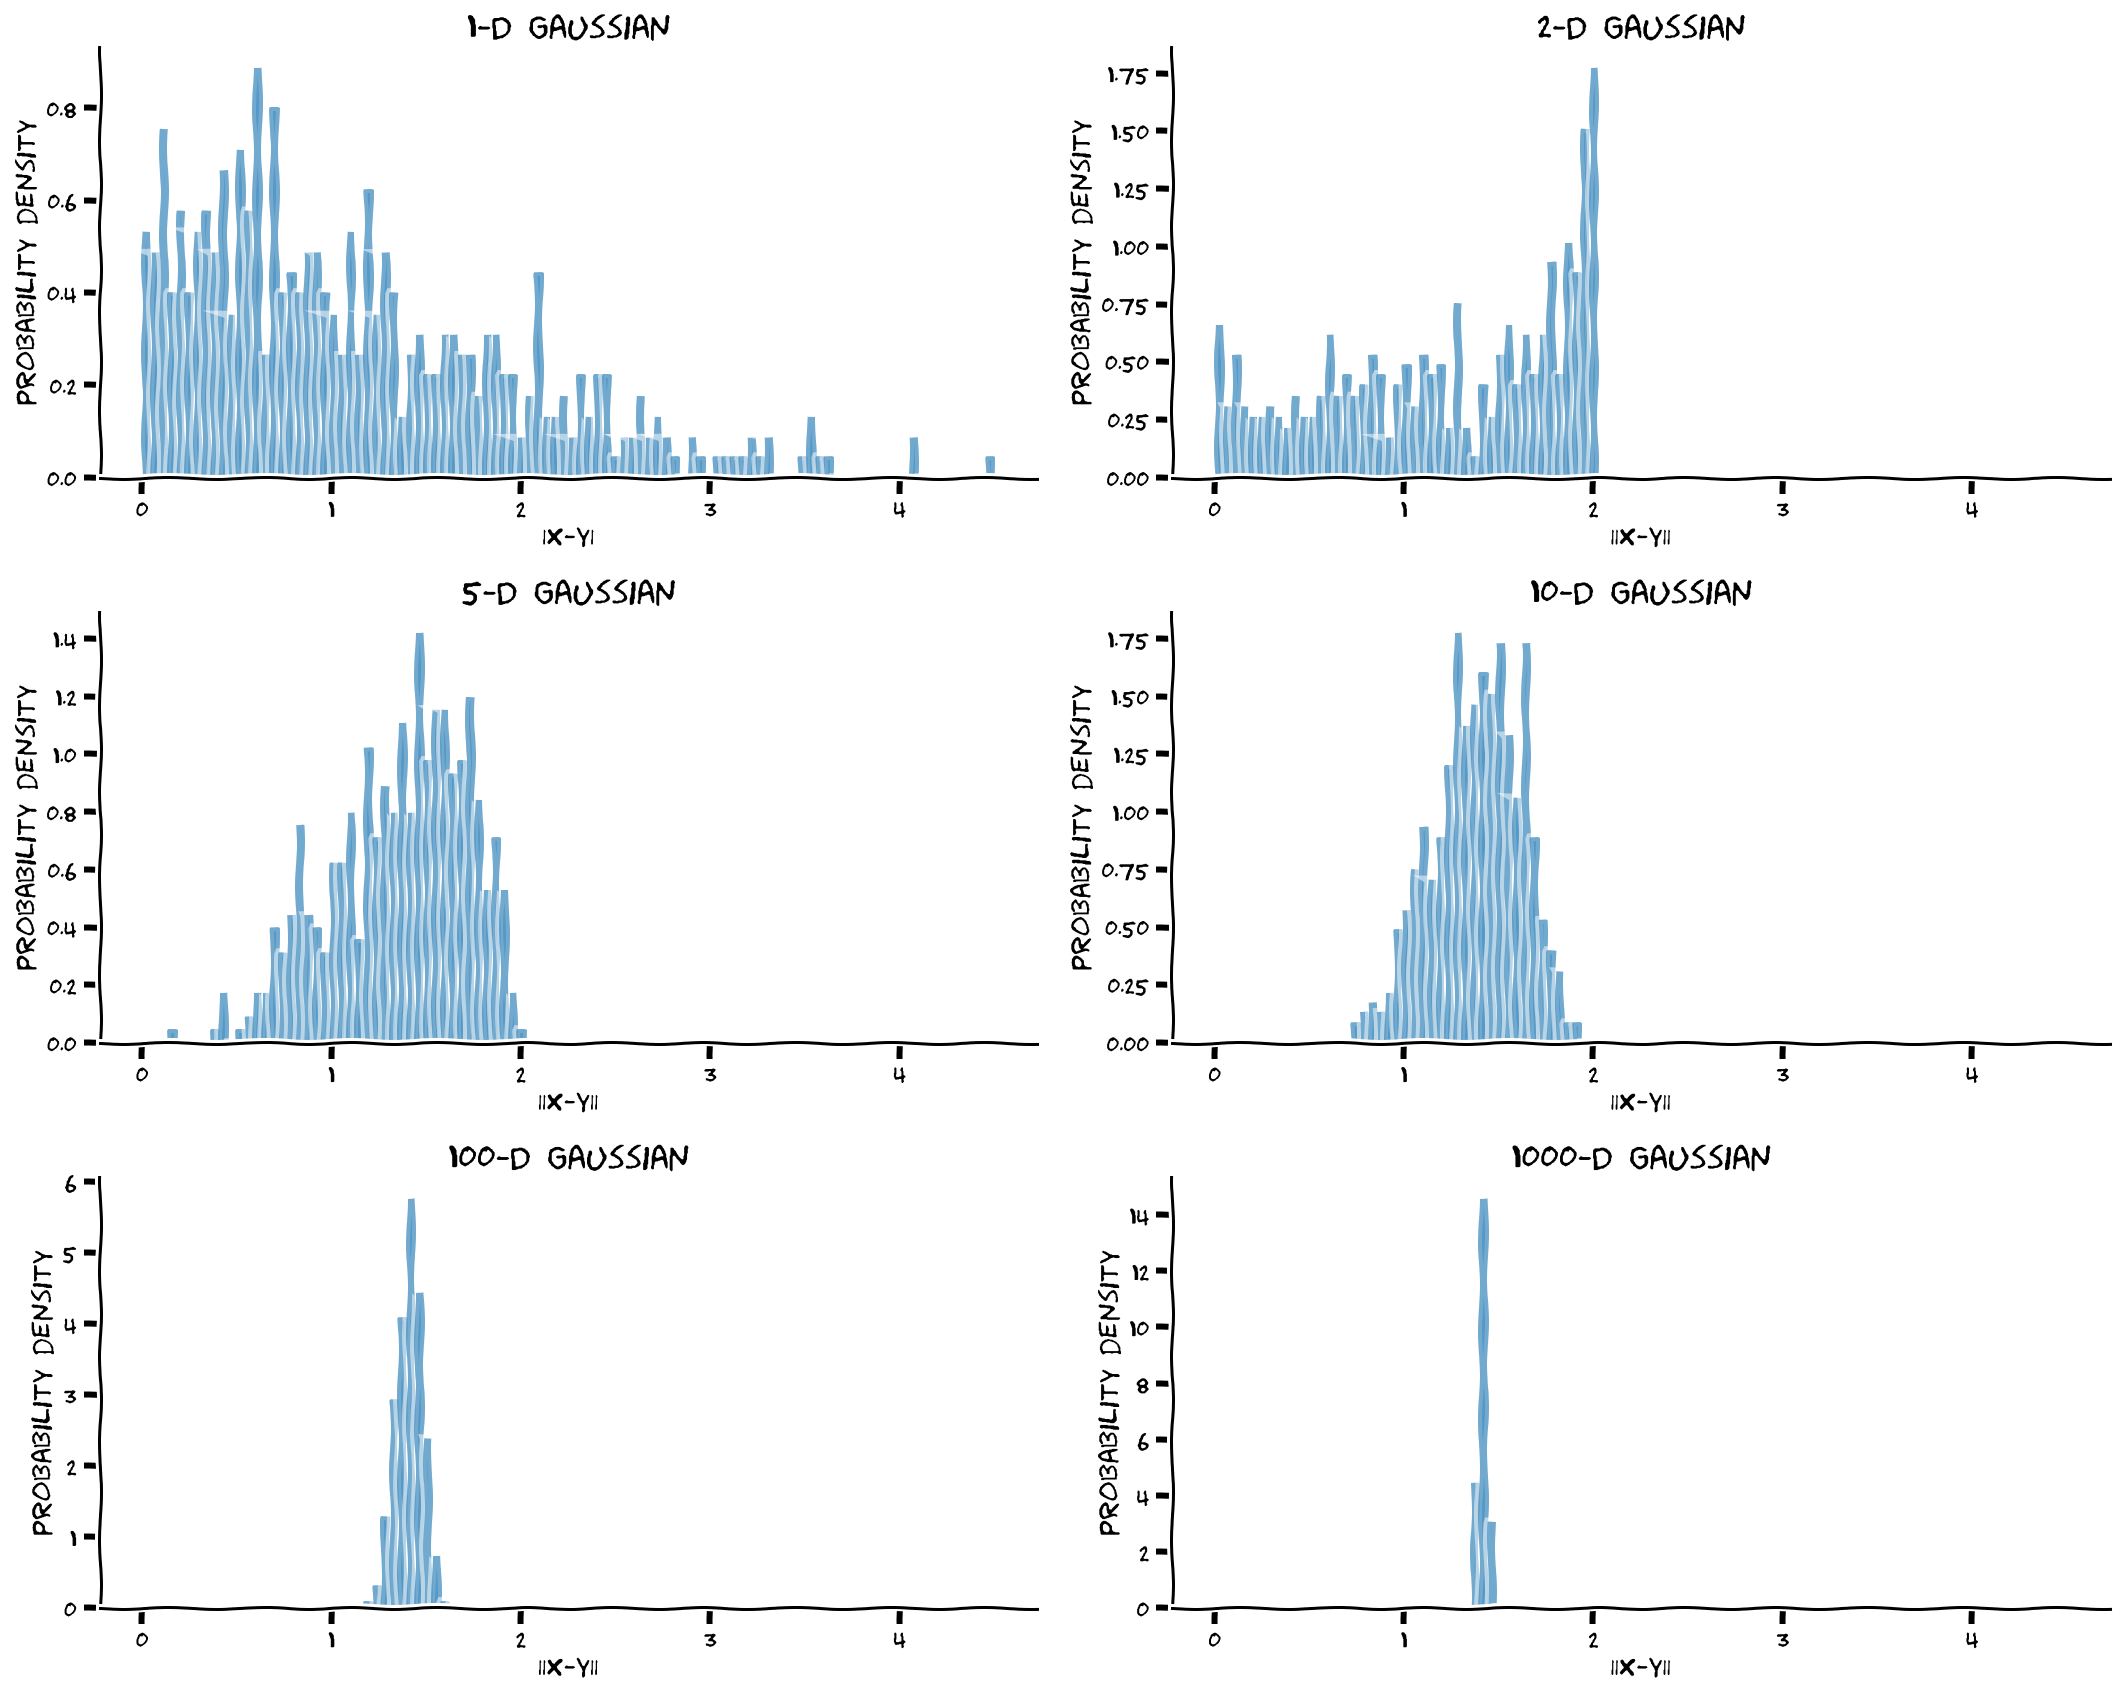

In [76]:
# to_remove solution


def plot_distances(sample_size, dimensions):

    plt.figure(figsize=(15, 12))
    for cnt, D in enumerate(dimensions):

        norms = []

        if D != 1:
            mean = np.zeros(D)
            cov = 2 * np.eye(D)  # diagonal covariance, i.e., isotropic gaussian
            x = np.random.multivariate_normal(mean, cov, size=sample_size).T
            x /= np.linalg.norm(x, axis=0).reshape(1, -1)
            y = np.random.multivariate_normal(mean, cov, size=sample_size).T
            y /= np.linalg.norm(y, axis=0).reshape(1, -1)
            norms = np.linalg.norm(x - y, axis=0, ord=2)

        elif D == 1:
            x = np.random.randn(sample_size)
            y = np.random.randn(sample_size)
            norms = np.abs(x - y)

        if cnt == 0:
            bins = np.histogram(norms, bins=100)[1]  # get the bin edges
        plt.subplot(3, 2, cnt + 1)
        plt.hist(norms, bins=bins, density=True, alpha=0.5)
        if D == 1:
            plt.xlabel("|x-y|")
        else:
            plt.xlabel("||x-y||")

        plt.ylabel("probability density")
        plt.title(f"{D}-D Gaussian")

    plt.tight_layout()


sample_size = 500
dimensions = [1, 2, 5, 10, 100, 1000]
with plt.xkcd():
    plot_distances(sample_size, dimensions)
